In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None
import pydot
from sklearn.tree import export_graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from IPython.display import Image
import matplotlib.image as mpimg
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import researchpy as rp
from statsmodels.formula.api import ols
from math import sqrt
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
os.chdir("C:/Users/Tom/Documents/Course/Semester 3/Project/Data Sets/")

In [3]:
#Importing the Indoor Air Quality sensor data
IAQ_LR = pd.read_csv("IAQ_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_KR = pd.read_csv("IAQ_kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_BR = pd.read_csv("IAQ_bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)

In [4]:
#Creating datasets to hold just the data for when devices were together for calibration purposes
Cal_LR = IAQ_LR[IAQ_LR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_KR = IAQ_KR[IAQ_KR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_BR = IAQ_BR[IAQ_BR["Calibration"] == 1].drop(["Calibration"], axis=1)

#Removing the calibration observations from our sensor data
IAQ_LR = IAQ_LR[IAQ_LR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_KR = IAQ_KR[IAQ_KR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_BR = IAQ_BR[IAQ_BR["Calibration"] == 0].drop(["Calibration"], axis=1)

In [5]:
#Bringing in the Occupant Activity. Shower holds a variable only used in House 2 to see if it made any impact on PM2.5
activity_LR = pd.read_csv("activity_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_KR = pd.read_csv("activity_Kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_BR = pd.read_csv("activity_Bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
shower = pd.read_csv("activity_bathroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)


In [6]:
#Joining all activities in the same dataset as they have unique names such as "LR_MaxOccupancy", "BR_MaxOccupancy" and so on.
activity = pd.merge(activity_LR, activity_KR, left_index=True, right_index=True).merge(
    activity_BR, left_index=True, right_index=True).merge(shower, left_index=True, right_index=True)

In [7]:
#To consider time as a feature in our model, we've created a feature storing all 24 hours and one for Time of day

activity['Hour'] = activity.index.strftime('%H').astype(int)
activity["timeOfDay"]=pd.cut(activity.index.hour, [-1, 5, 11, 17, 24], labels=['Night', "Morning", 'Afternoon', 'Evening'])
activity["timeOfDay"] = activity["timeOfDay"].cat.codes

# Calibration

In this section we'll analyse the calibration plots for House 1 and 2 for all sensor features. If they're highly correlated, we'll bring their into agreement through their difference in means. If not, they'll be excluded from the model.

In [ ]:
###############################################################################
################################## P M 2 . 5 ##################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 2")
plt.show();

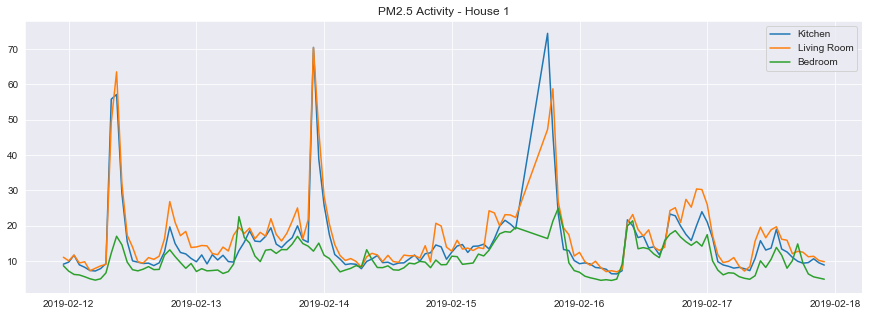

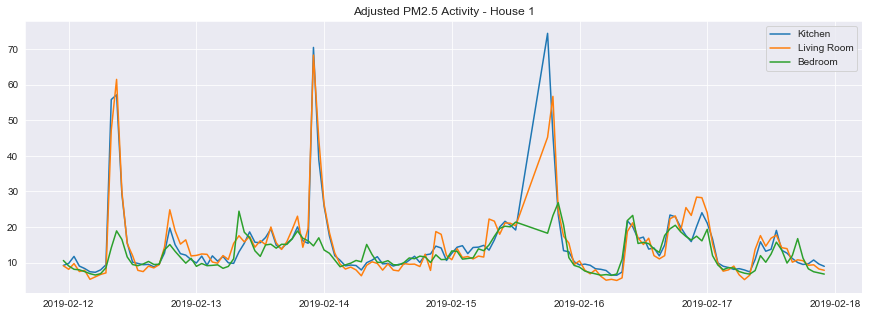

In [8]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 1")
plt.show()

KR1_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==1].mean()
LR1_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==1].mean()
BR1_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==1].mean()

H1_Cal_PM25_mean = (KR1_Cal_PM25_mean + LR1_Cal_PM25_mean + BR1_Cal_PM25_mean)/3

KR1_PM25_adjustment = KR1_Cal_PM25_mean - H1_Cal_PM25_mean
LR1_PM25_adjustment = LR1_Cal_PM25_mean - H1_Cal_PM25_mean
BR1_PM25_adjustment = BR1_Cal_PM25_mean - H1_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==1] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==1] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==1] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 1")
plt.show();

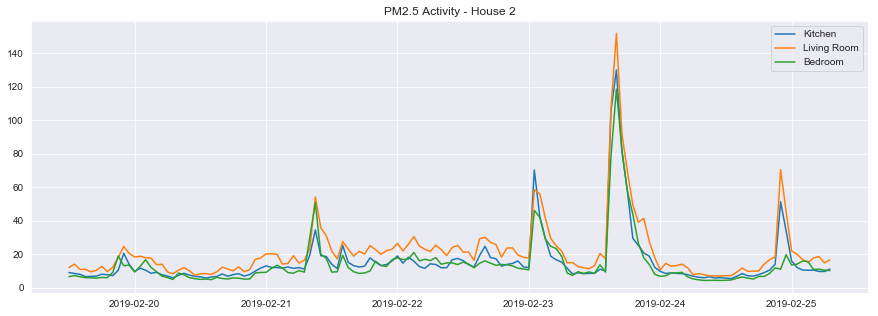

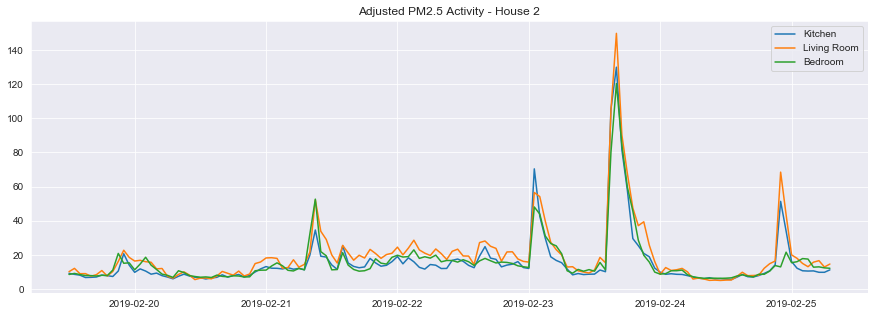

In [9]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 2")
plt.show()

KR2_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==2].mean()
LR2_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==2].mean()
BR2_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==2].mean()

H2_Cal_PM25_mean = (KR2_Cal_PM25_mean + LR2_Cal_PM25_mean + BR2_Cal_PM25_mean)/3

KR2_PM25_adjustment = KR2_Cal_PM25_mean - H2_Cal_PM25_mean
LR2_PM25_adjustment = LR2_Cal_PM25_mean - H2_Cal_PM25_mean
BR2_PM25_adjustment = BR2_Cal_PM25_mean - H2_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==2] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==2] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==2] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 2")
plt.show();

In [ ]:
###############################################################################
#################################### C O 2 ####################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 2")
plt.show();

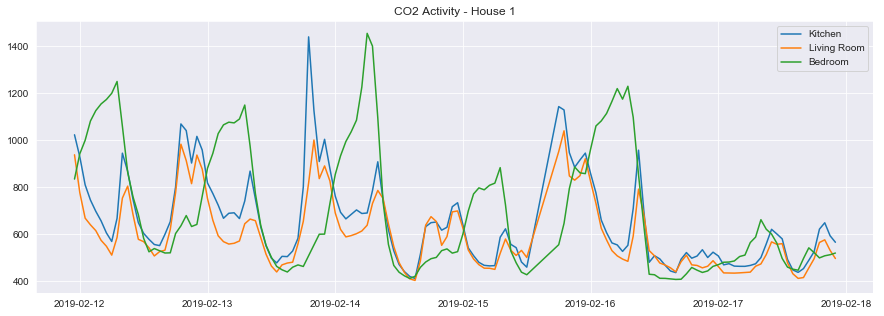

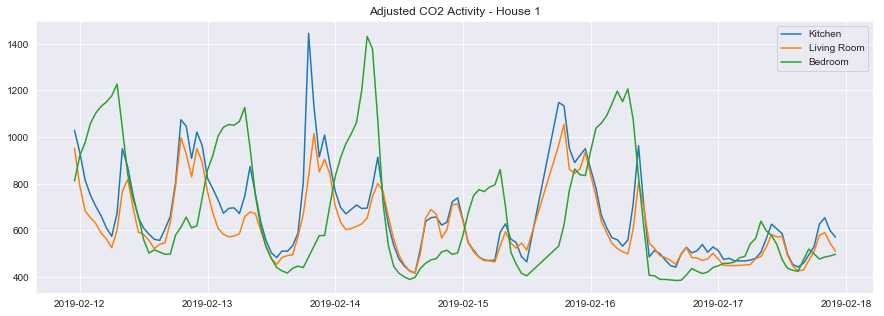

In [10]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 1")
plt.show()

KR1_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==1].mean()
LR1_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==1].mean()
BR1_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==1].mean()

H1_Cal_CO2_mean = (KR1_Cal_CO2_mean + LR1_Cal_CO2_mean + BR1_Cal_CO2_mean)/3

KR1_CO2_adjustment = KR1_Cal_CO2_mean - H1_Cal_CO2_mean
LR1_CO2_adjustment = LR1_Cal_CO2_mean - H1_Cal_CO2_mean
BR1_CO2_adjustment = BR1_Cal_CO2_mean - H1_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==1] -= KR1_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==1] -= LR1_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==1] -= BR1_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 1")
plt.show();

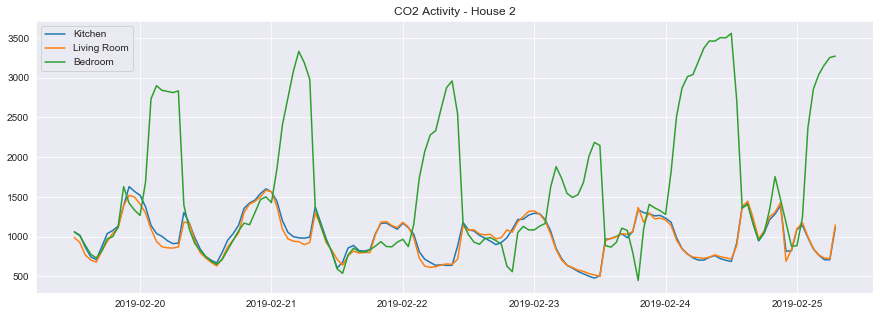

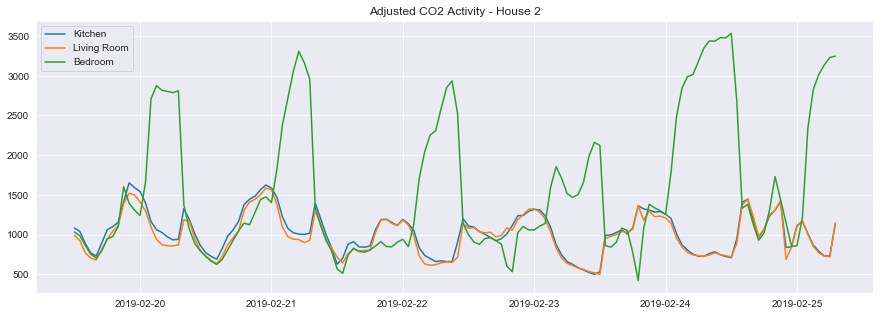

In [11]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 2")
plt.show()

KR2_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==2].mean()
LR2_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==2].mean()
BR2_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==2].mean()

H2_Cal_CO2_mean = (KR2_Cal_CO2_mean + LR2_Cal_CO2_mean + BR2_Cal_CO2_mean)/3

KR2_CO2_adjustment = KR2_Cal_CO2_mean - H2_Cal_CO2_mean
LR2_CO2_adjustment = LR2_Cal_CO2_mean - H2_Cal_CO2_mean
BR2_CO2_adjustment = BR2_Cal_CO2_mean - H2_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==2] -= KR2_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==2] -= LR2_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==2] -= BR2_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 2")
plt.show();

In [ ]:
###############################################################################
################################### T V O C ###################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 2")
plt.show();

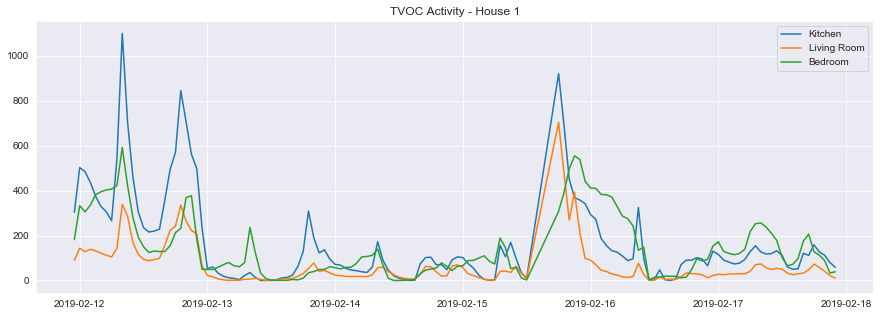

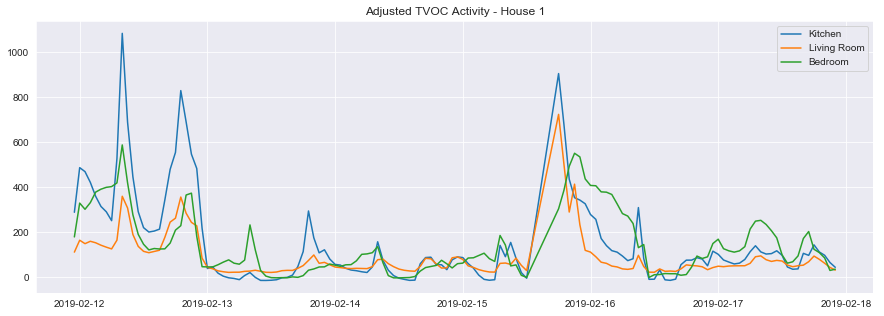

In [12]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 1")
plt.show()

KR1_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==1].mean()
LR1_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==1].mean()
BR1_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==1].mean()

H1_Cal_TVOC_mean = (KR1_Cal_TVOC_mean + LR1_Cal_TVOC_mean + BR1_Cal_TVOC_mean)/3

KR1_TVOC_adjustment = KR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
LR1_TVOC_adjustment = LR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
BR1_TVOC_adjustment = BR1_Cal_TVOC_mean - H1_Cal_TVOC_mean

IAQ_KR["adj_TVOC"] = IAQ_KR["TVOC"][IAQ_KR["House"]==1] - KR1_TVOC_adjustment
IAQ_LR["adj_TVOC"] = IAQ_LR["TVOC"][IAQ_LR["House"]==1] - LR1_TVOC_adjustment
IAQ_BR["adj_TVOC"] = IAQ_BR["TVOC"][IAQ_BR["House"]==1] - BR1_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 1")
plt.show();

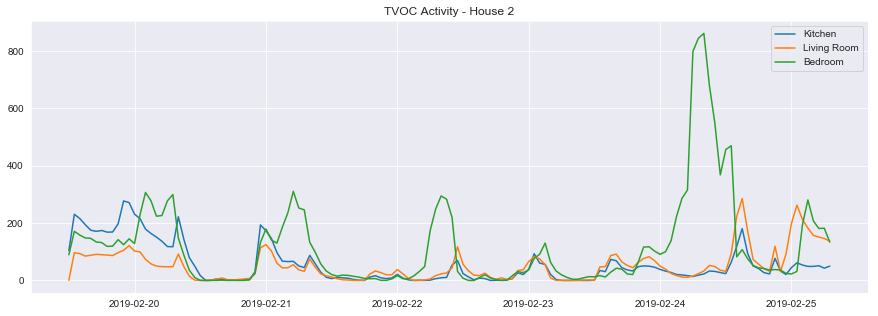

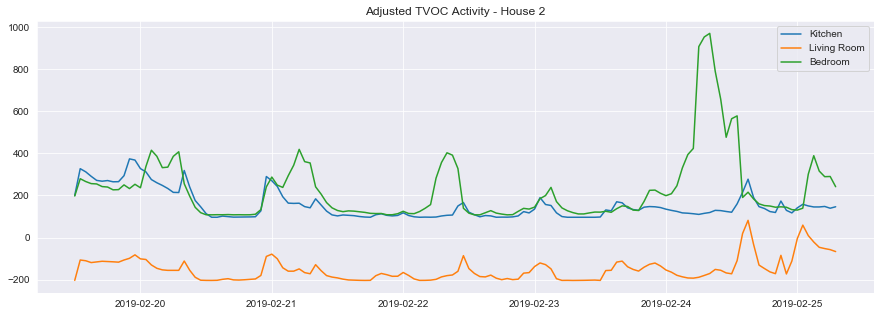

In [13]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 2")
plt.show()

KR2_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==2].mean()
LR2_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==2].mean()
BR2_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==2].mean()

H2_Cal_TVOC_mean = (KR2_Cal_TVOC_mean + LR2_Cal_TVOC_mean + BR2_Cal_TVOC_mean)/3

KR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
LR2_TVOC_adjustment = LR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
BR2_TVOC_adjustment = BR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_KR["adj_TVOC"][IAQ_KR["House"]==2] = IAQ_KR["TVOC"][IAQ_KR["House"]==2] - KR2_TVOC_adjustment
IAQ_LR["adj_TVOC"][IAQ_LR["House"]==2] = IAQ_LR["TVOC"][IAQ_LR["House"]==2] - LR2_TVOC_adjustment
IAQ_BR["adj_TVOC"][IAQ_BR["House"]==2] = IAQ_BR["TVOC"][IAQ_BR["House"]==2] - BR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

Due to how big the discrepancy is between the Living Room sensor and all the others during House 2's calibration period, applying the same formula we've been using before puts this value into the negative spectrum. As both houses have an open plan Kitchen and the kitchen and living room sensors show a high level of accordance, we'll use the calibration data from the Kitchen for the living room sensor, pending a better idea.

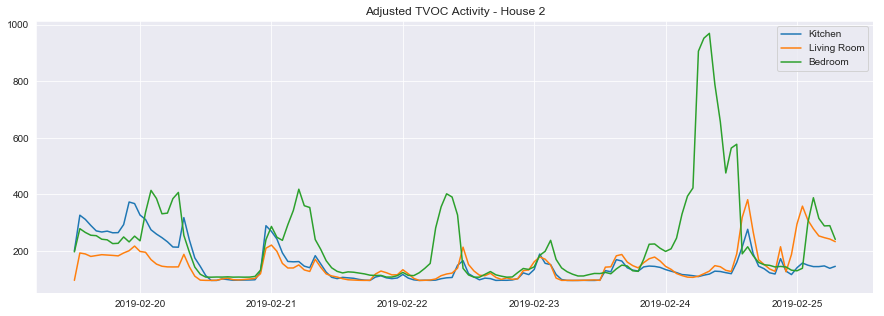

In [14]:
###############################################################################
####################### T V O C - A L T E R N A T I V E #######################
###############################################################################
################################ H O U S E   2 ################################
###############################################################################

#This is the line we've modified
LR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_LR["adj_TVOC"][IAQ_LR["House"]==2] = IAQ_LR["TVOC"][IAQ_LR["House"]==2] - LR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

In [ ]:
###############################################################################
############################ T E M P E R A T U R E ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 2")
plt.show();

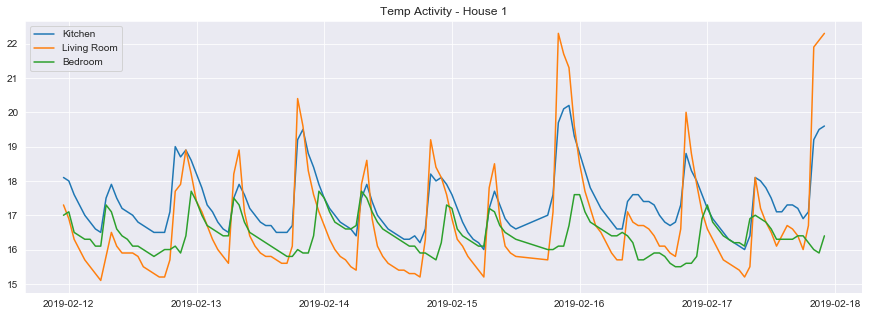

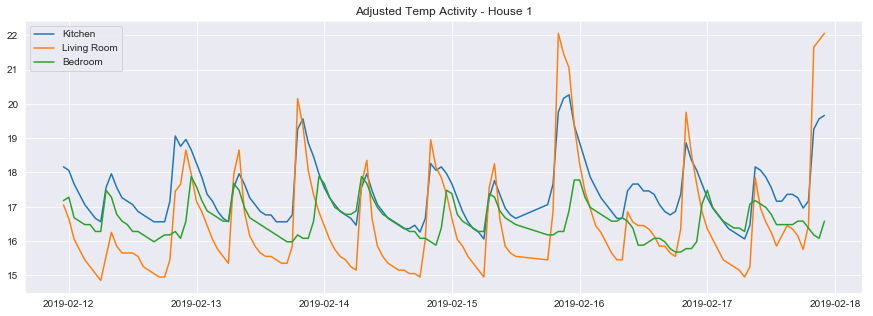

In [15]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 1")
plt.show()

KR1_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==1].mean()
LR1_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==1].mean()
BR1_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==1].mean()

H1_Cal_Temp_mean = (KR1_Cal_Temp_mean + LR1_Cal_Temp_mean + BR1_Cal_Temp_mean)/3

KR1_Temp_adjustment = KR1_Cal_Temp_mean - H1_Cal_Temp_mean
LR1_Temp_adjustment = LR1_Cal_Temp_mean - H1_Cal_Temp_mean
BR1_Temp_adjustment = BR1_Cal_Temp_mean - H1_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==1] -= KR1_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==1] -= LR1_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==1] -= BR1_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 1")
plt.show();

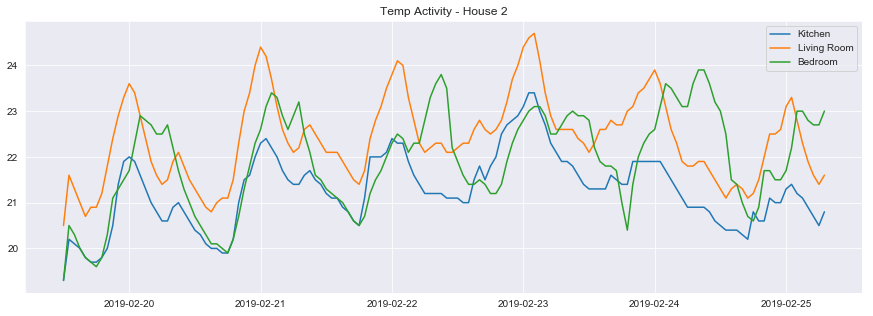

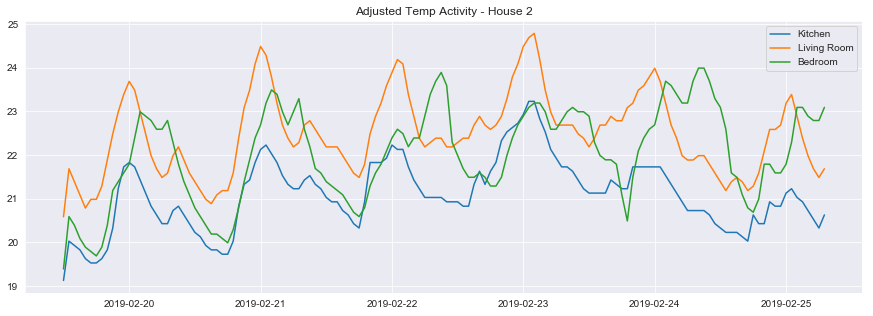

In [16]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 2")
plt.show()

KR2_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==2].mean()
LR2_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==2].mean()
BR2_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==2].mean()

H2_Cal_Temp_mean = (KR2_Cal_Temp_mean + LR2_Cal_Temp_mean + BR2_Cal_Temp_mean)/3

KR2_Temp_adjustment = KR2_Cal_Temp_mean - H2_Cal_Temp_mean
LR2_Temp_adjustment = LR2_Cal_Temp_mean - H2_Cal_Temp_mean
BR2_Temp_adjustment = BR2_Cal_Temp_mean - H2_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==2] -= KR2_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==2] -= LR2_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==2] -= BR2_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 2")
plt.show();

In [ ]:
###############################################################################
###################### R E L A T I V E   H U M I D I T Y ######################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 2")
plt.show();

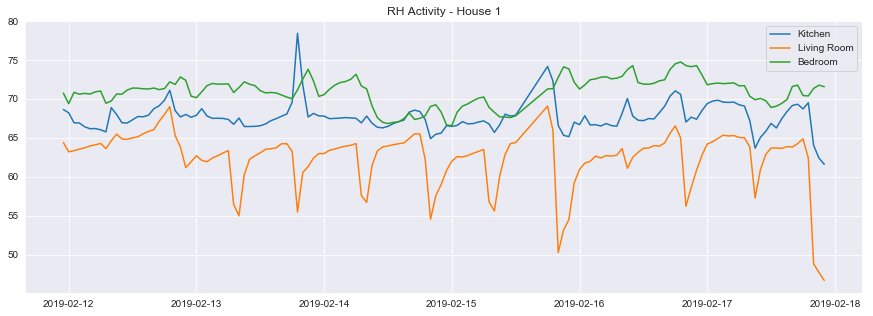

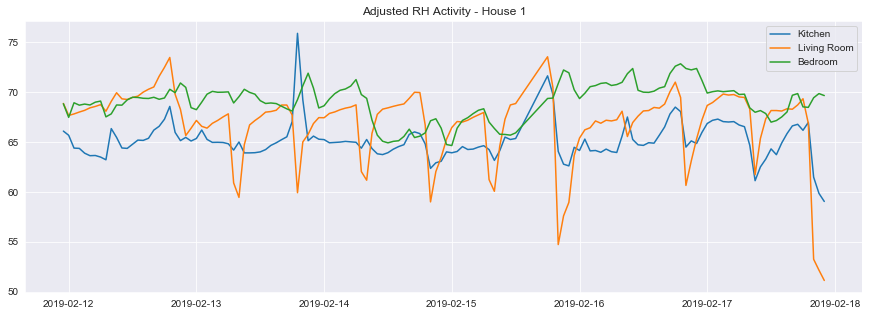

In [17]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 1")
plt.show()

KR1_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==1].mean()
LR1_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==1].mean()
BR1_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==1].mean()

H1_Cal_RH_mean = (KR1_Cal_RH_mean + LR1_Cal_RH_mean + BR1_Cal_RH_mean)/3

KR1_RH_adjustment = KR1_Cal_RH_mean - H1_Cal_RH_mean
LR1_RH_adjustment = LR1_Cal_RH_mean - H1_Cal_RH_mean
BR1_RH_adjustment = BR1_Cal_RH_mean - H1_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==1] -= KR1_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==1] -= LR1_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==1] -= BR1_RH_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 1")
plt.show();

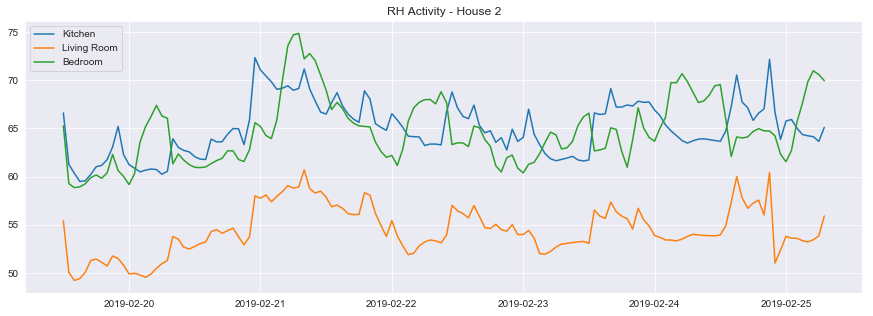

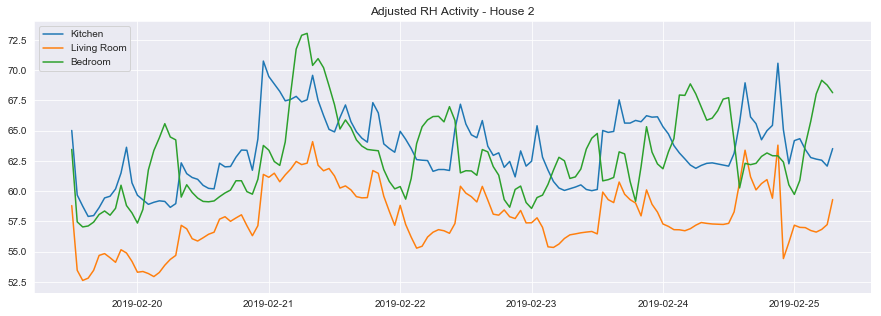

In [18]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 2")
plt.show()

KR2_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==2].mean()
LR2_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==2].mean()
BR2_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==2].mean()

H2_Cal_RH_mean = (KR2_Cal_RH_mean + LR2_Cal_RH_mean + BR2_Cal_RH_mean)/3

KR2_RH_adjustment = KR2_Cal_RH_mean - H2_Cal_RH_mean
LR2_RH_adjustment = LR2_Cal_RH_mean - H2_Cal_RH_mean
BR2_RH_adjustment = BR2_Cal_RH_mean - H2_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==2] -= KR2_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==2] -= LR2_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==2] -= BR2_RH_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 2")
plt.show();

In [ ]:
###############################################################################
########################### A I R   P R E S S U R E ###########################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 2")
plt.show();

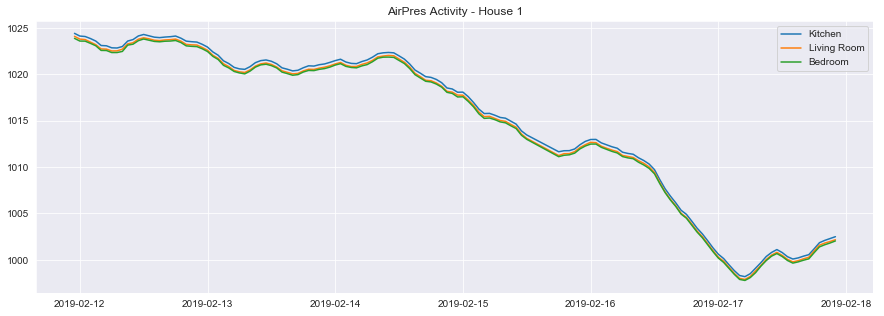

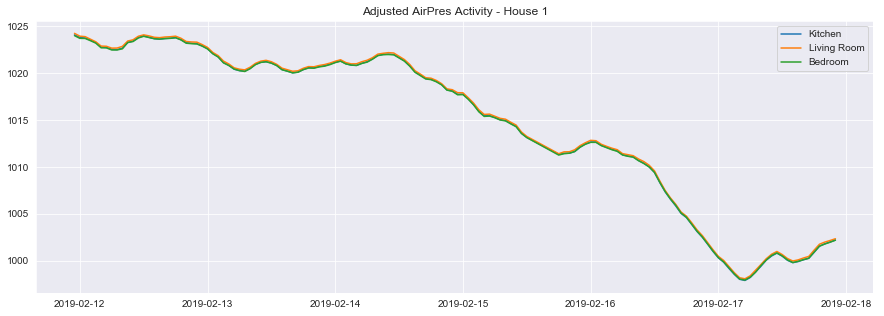

In [19]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 1")
plt.show()

KR1_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==1].mean()
LR1_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==1].mean()
BR1_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==1].mean()

H1_Cal_AirPres_mean = (KR1_Cal_AirPres_mean + LR1_Cal_AirPres_mean + BR1_Cal_AirPres_mean)/3

KR1_AirPres_adjustment = KR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
LR1_AirPres_adjustment = LR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
BR1_AirPres_adjustment = BR1_Cal_AirPres_mean - H1_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==1] -= KR1_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==1] -= LR1_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==1] -= BR1_AirPres_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 1], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 1], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 1")
plt.show();

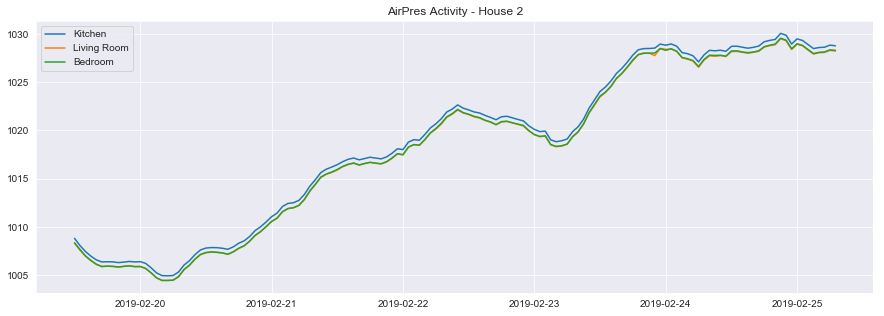

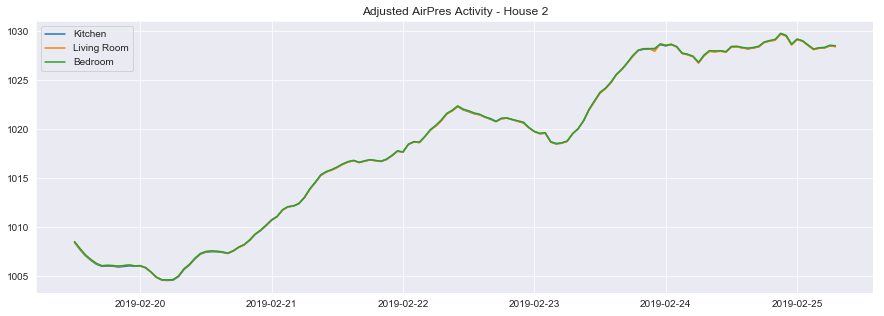

In [20]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 2")
plt.show()

KR2_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==2].mean()
LR2_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==2].mean()
BR2_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==2].mean()

H2_Cal_AirPres_mean = (KR2_Cal_AirPres_mean + LR2_Cal_AirPres_mean + BR2_Cal_AirPres_mean)/3

KR2_AirPres_adjustment = KR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
LR2_AirPres_adjustment = LR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
BR2_AirPres_adjustment = BR2_Cal_AirPres_mean - H2_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==2] -= KR2_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==2] -= LR2_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==2] -= BR2_AirPres_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 2")
plt.show();

In [ ]:
###############################################################################
############################ O Z O N E   &   N O 2 ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 2")
plt.show();

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 1], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 1], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 1], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 2")
plt.show();

In [21]:
#We're excluding Ozone and NO2 from our model since we couldn't find any agreement in the calibration data
#Here we join the sensor data from our 3 rooms, Living Room, Kitchen and Bedroom with all activity available

IAQ_LR = IAQ_LR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_KR = IAQ_KR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_BR = IAQ_BR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 

LR = pd.merge(IAQ_LR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
KR = pd.merge(IAQ_KR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
BR = pd.merge(IAQ_BR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)

In [22]:
#Here we create datasets for each room in each house and one for both rooms together. We do this as House 2 has slightly more
#features available than House 1. The purpose of this split is to analyze which features are most impactful to PM2.5 and if
#these features are equally impactful in both houses or not.

LR1 = LR[LR["House"] == 1].dropna(axis=1)
LR2 = LR[LR["House"] == 2].dropna(axis=1)
LR = LR.dropna(axis=1)

KR1 = KR[KR["House"] == 1].dropna(axis=1)
KR2 = KR[KR["House"] == 2].dropna(axis=1)
KR = KR.dropna(axis=1)

BR1 = BR[BR["House"] == 1].dropna(axis=1)
BR2 = BR[BR["House"] == 2].dropna(axis=1)
BR = BR.dropna(axis=1)

print("LR1 shape:",LR1.shape)
print("LR2 shape,",LR2.shape)
print("LR shape:",LR.shape)
print("\n")
print("KR1 shape:",KR1.shape)
print("KR2 shape,",KR2.shape)
print("KR shape:",KR.shape)
print("\n")
print("BR1 shape:",BR1.shape)
print("BR2 shape,",BR2.shape)
print("BR shape:",BR.shape)



LR1 shape: (131, 32)
LR2 shape, (139, 36)
LR shape: (270, 32)


KR1 shape: (131, 32)
KR2 shape, (139, 36)
KR shape: (270, 32)


BR1 shape: (131, 32)
BR2 shape, (139, 36)
BR shape: (270, 32)


In [23]:
print (LR1.columns)
print (LR2.columns)
print("\n")
print("Features in House 2 unavailable in House 1: LR_OpenDoor, BR_OpenDoor, KR_OpenDoor and Shower")

Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'House', 'TVOC',
       'LR_MaxOccupancy', 'LR_OpenWindow', 'LR_OpenCurtains', 'FireLit',
       'LR_HeatingOn', 'LR_Hoovering', 'LR_Mopping', 'KR_MaxOccupancy',
       'KR_OpenCurtains', 'Boiling', 'Frying', 'KR_HeatingOn', 'KR_Hoovering',
       'KR_Mopping', 'DishwasherOn', 'WashingMachineOn', 'Toaster',
       'BR_MaxOccupancy', 'BR_OpenWindow', 'BR_OpenCurtains', 'BR_HeatingOn',
       'BR_Hoovering', 'BR_Mopping', 'Hour', 'timeOfDay'],
      dtype='object')
Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'House', 'TVOC',
       'LR_MaxOccupancy', 'LR_OpenWindow', 'LR_OpenDoor', 'LR_OpenCurtains',
       'FireLit', 'LR_HeatingOn', 'LR_Hoovering', 'LR_Mopping',
       'KR_MaxOccupancy', 'KR_OpenDoor', 'KR_OpenCurtains', 'Boiling',
       'Frying', 'KR_HeatingOn', 'KR_Hoovering', 'KR_Mopping', 'DishwasherOn',
       'WashingMachineOn', 'Toaster', 'BR_MaxOccupancy', 'BR_OpenWindow',
       'BR_OpenDoor', 'BR_OpenCurtains', 'BR_HeatingOn

In [24]:
#Creating a DF for House 1 (H1), House 2 (H2) and both houses (H) with rooms one-hot encoded in case I need it for something.
df1_1 = LR1.copy()
df1_2 = KR1.copy()
df1_3 = BR1.copy()

df2_1 = LR2.copy()
df2_2 = KR2.copy()
df2_3 = BR2.copy()

df1_1["LivingRoom"] = 1
df1_1["Kitchen"] = 0
df1_1["Bedroom"] = 0

df1_2["LivingRoom"] = 0
df1_2["Kitchen"] = 1
df1_2["Bedroom"] = 0

df1_3["LivingRoom"] = 0
df1_3["Kitchen"] = 0
df1_3["Bedroom"] = 1

df2_1["LivingRoom"] = 1
df2_1["Kitchen"] = 0
df2_1["Bedroom"] = 0

df2_2["LivingRoom"] = 0
df2_2["Kitchen"] = 1
df2_2["Bedroom"] = 0

df2_3["LivingRoom"] = 0
df2_3["Kitchen"] = 0
df2_3["Bedroom"] = 1


H1 = pd.concat([df1_1, df1_2, df1_3], axis=0, sort=False)
H2 = pd.concat([df2_1, df2_2, df2_3], axis=0, sort=False)

H = pd.concat([H1, H2], axis=0, sort=False).dropna(axis=1)

print("H1 shape:",H1.shape)
print("H2 shape:",H2.shape)
print("H shape:",H.shape)

H1 shape: (393, 35)
H2 shape: (417, 39)
H shape: (810, 35)


# Questions needing answering so far:

1 - Is there a better way to use the calibration data on our activity?  
2 - Assuming the way the sensors were adjusted is acceptable, is there a better way to treat the TVOC data?

# Exploratory Data Analysis

## Goals of this section:

We're dealing with two similar layout houses. Both houses have the Kitchen joined with the Living room and then a bedroom too.

1 - Comparing means, standard deviations, mins and maximums between rooms in House 1 and 2; 6 comparisons.  
2 - Comparing means between Activities' 1s and 0s. A "1" represents "On/Open/Yes", such as Heating On, Door Open, Frying occurred.  
3 - We'll look into collinearity in this section as well as to prevent having a model with many features irrelevant to the change of PM2.5  
4 - Related to the mins/max comparison, we'll look at outliers and consult our activity logs to try and explain what could have happened there

### Brief talk on PM2.5

#### What is it?
PM2.5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair. They describe the mixture of solid particles and liquid droplets in the air.  It can be either human-made or naturally occurring.

#### Sources: 

Some examples include dust, ash and sea-spray. Particulate matter (including soot) is emitted during the combustion of solid and liquid fuels, such as for power generation, domestic heating and in vehicle engines. Studies (https://journals.sagepub.com/doi/pdf/10.1177/1420326X15604349) have shown that Indoor PM2.5 concentrations were dominated by outdoor sources in residential homes and public buildings where the I/O ratio was close to one or slightly higher than one. As such, when looking at our data, it's extremely important to know several external factors such as if the house is located near a road, within a city or in a more rural environment and so on.


For the purposes of our analysis, these are the property features for House 1 // House 2

Central heating - oil // gas  
Pump: Solar pump // none  
Electric heating: no // no  
BER rating - B3 // unknown  
Location - adjacent to town on country lane // right outside a busy crossroads in city centre  
Type: detached // flat  
Close neighbours: yes // yes  
Busy road close by: no // yes  
Solid fuel used for heating - wood // none  
Do neighbours burn solid fuel? - yes // no  
near farmyard - yes // no  
forested area: no // no  

Rooms:  

Kitchen  
Approximate size (in m2): 23.2 //  4.77
Number of windows: 1 // 0  
Number of doors: 1 // 1  
Orientation: SE // NE  
Floor: tiles // wood  
Plants: yes // no  

Location of sensor (in m)  
Distance from door: 5.8  // 2.83
Distance from window: 0.58  // no window
Height above floor: 1.32  // 0.95
Distance from wall: 0.22  // 0.35


Living Room  
Approximate size (in m2): 22.8 //  8.16
Number of windows: 2 // 2  
Number of doors: 2 // 1  
Orientation: SW // NW  
Floor: carpet // wood  
Plants: yes // no  

Location of sensor (in m)  
Distance from door: 6  // 3.6
Distance from window: 6.5 // 1.75
Height above floor: 0.54 // 1.03
Distance from wall: 0.23 // 0.2


Bedroom  
Approximate size (in m2): 30.9 //  7.44
Number of windows: 4 // 1  
Number of doors: 1 // 1  
Orientation: NW // SW  
Floor: carpet // wood  
Plants: no // no  

Location of sensor (in m)  
Distance from door: 3  // 3.95
Distance from window: 6  // 0.9
Height above floor: 0.8  // 0.78
Distance from wall: 0.22 // 0.2

In [ ]:
H.describe()

#### 2 problems are apparent:

1 - PM2.5 has a very high standard deviation, likely due to some outliers as we see the max to be 149.77.  
2 - The adjustement got TVOC some negative values as seen on the min.

In [25]:
LR1_mean = round(LR1["PM2.5"].mean(),4)
LR1_std = round(LR1["PM2.5"].std(),4)
LR1_min = round(LR1["PM2.5"].min(),4)
LR1_max = round(LR1["PM2.5"].max(),4)

KR1_mean = round(KR1["PM2.5"].mean(),4)
KR1_std = round(KR1["PM2.5"].std(),4)
KR1_min = round(KR1["PM2.5"].min(),4)
KR1_max = round(KR1["PM2.5"].max(),4)

BR1_mean = round(BR1["PM2.5"].mean(),4)
BR1_std = round(BR1["PM2.5"].std(),4)
BR1_min = round(BR1["PM2.5"].min(),4)
BR1_max = round(BR1["PM2.5"].max(),4)

LR2_mean = round(LR2["PM2.5"].mean(),4)
LR2_std = round(LR2["PM2.5"].std(),4)
LR2_min = round(LR2["PM2.5"].min(),4)
LR2_max = round(LR2["PM2.5"].max(),4)

KR2_mean = round(KR2["PM2.5"].mean(),4)
KR2_std = round(KR2["PM2.5"].std(),4)
KR2_min = round(KR2["PM2.5"].min(),4)
KR2_max = round(KR2["PM2.5"].max(),4)

BR2_mean = round(BR2["PM2.5"].mean(),4)
BR2_std = round(BR2["PM2.5"].std(),4)
BR2_min = round(BR2["PM2.5"].min(),4)
BR2_max = round(BR2["PM2.5"].max(),4)


descriptives = {'Mean':[LR1_mean, KR1_mean, BR1_mean, LR2_mean, KR2_mean, BR2_mean], 
               'STD':[LR1_std, KR1_std, BR1_std, LR2_std, KR2_std, BR2_std],
               'Min':[LR1_min, KR1_min, BR1_min, LR2_min, KR2_min, BR2_min],
               'Max':[LR1_max, KR1_max, BR1_max, LR2_max, KR2_max, BR2_max],} 

descriptive_df = pd.DataFrame(descriptives, index =['LR1', 'KR1', 'BR1', 'LR2', 'KR2', 'BR2']) 

descriptive_df 

Mean      STD     Min       Max
LR1  15.4555  10.3329  4.9670   68.3370
KR1  15.3166  10.5639  6.4297   74.4497
BR1  12.7807   4.3725  6.4033   26.8333
LR2  19.7132  18.6067  4.9870  149.7770
KR2  15.4854  16.5718  5.5397  129.9497
BR2  16.0845  14.8640  6.2233  120.3733

- LR1 and KR1 are very similar as they refer to a shared Kitchen and Living room. The sensors have been placed on opposite sides of the room

- BR seems to have the smallest deviation in data from both sets which is to be expected as activities that generate PM2.5 (cooking, fireplace) aren't common there

- Like LR1 and KR1, KR2 and LR2 refer to a joint Kitchen and Living room, however there's a clear increase in the mean on LR2. We'll have to investigate that further.

### Here we look for the most correlated features per room in each house. Count of activity occurrences and causation not accounted for here, we're just looking at the big picture for now and see if we have similar features affecting the same houses and/or the same rooms.

In [ ]:
def corr_matrix(df):

    df_corr_matrix=df.corr()["PM2.5"].drop(df.corr().index[2])
    best_features_list = df_corr_matrix[abs(df_corr_matrix) >= 0.3].sort_values(ascending=False)
    weak_features_list = df_corr_matrix[(abs(df_corr_matrix) >= 0.2) & (abs(df_corr_matrix) < 0.3)].sort_values(ascending=False)

    print("There are {} moderately (> 0.3) correlated values with PM2.5:\n{}".format(len(best_features_list), best_features_list))
    print('\n')
    print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))

In [ ]:
corr_matrix(LR1)

In [ ]:
corr_matrix(KR1)

In [ ]:
corr_matrix(BR1)

In [ ]:
corr_matrix(LR2)

In [ ]:
corr_matrix(KR2)

In [ ]:
corr_matrix(BR2)

In [ ]:
corr_matrix(LR)

In [ ]:
corr_matrix(KR)

In [ ]:
corr_matrix(BR)

In [ ]:
corr_matrix(H1)

In [ ]:
corr_matrix(H2)

In [ ]:
corr_matrix(H)

### With the distribution plots for House 1, House 2 and their combination, we aim to look at how PM2.5 is distributed and where the possible outliers lie in.

In [ ]:
#Distribution plots for House 1

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(LR1["PM2.5"])
plt.xlim(0, 80)
plt.title("PM2.5 - House 1 - Living Room", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(KR1["PM2.5"])
plt.xlim(0, 80)
plt.title("PM2.5 - House 1 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(BR1["PM2.5"])
plt.xlim(0, 80)
plt.title("PM2.5 - House 1 - Bedroom", size=20)
plt.show()

We immediately see the Kitchen and Living room showing some outliers on the 40 μg/m3 mark. This will need to be looked into.

In [ ]:
#Distribution plots for House 2

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(LR2["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - House 2 - Living Room", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(KR2["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - House 2 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(BR2["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - House 2 - Bedroom", size=20)
plt.show()

In [ ]:
#Distribution plots per Room

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(LR["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - Both houses - Living Room", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(KR["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - Both houses - Kitchen", size=20)
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(BR["PM2.5"])
plt.xlim(0, 160)
plt.title("PM2.5 - Both houses - Bedroom", size=20)
plt.show()

# Boxplots

Here we first compare the mean PM.25 of all 3 rooms in both houses and then we compare most predictors against PM2.5 for both houses.

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x=LR['House'], y=LR['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by House", size=20)
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=KR['House'], y=KR['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by House", size=20)
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=BR['House'], y=BR['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by House", size=20)
plt.show()

House 2 has considerably more outliers than 1. Given their rather different room dimensions, it could explain why most of the Kitchen and Living Room outliers didn't seep into the Bedroom.

House 2 has 4 features that House 1 doesn't have; shower, LR_OpenDoor, KR_OpenDoor and BR_OpenDoor. We'll look at these first.

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x=LR2['Shower'], y=LR2['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by Shower activity", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x=KR2['Shower'], y=KR2['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by Shower activity", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x=BR2['Shower'], y=BR2['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by Shower activity", size=20)
plt.show();

LR2['Shower'].value_counts()

We weren't able to see any noticeable differences in the level of PM with the activity of Shower, as this mostly would affect a room we are not tracking and we only have 9 observations out of 139 where Shower is active.

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x=LR2['LR_OpenDoor'], y=LR2['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 with Door Closed/Open", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x=KR2['KR_OpenDoor'], y=KR2['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 with Door Closed/Open", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x=BR2['BR_OpenDoor'], y=BR2['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 with Door Closed/Open", size=20)
plt.show();

print('\nLiving Room Door open/closed counts:\n',LR2['LR_OpenDoor'].value_counts())
print('\nKitchen open/closed counts:\n',KR2['KR_OpenDoor'].value_counts())
print('\nBedroom open/closed counts:\n',BR2['BR_OpenDoor'].value_counts())

The only room with a considerable count of both "1"s and "0"s is the Bedroom and there doesn't seem to be any difference in PM2.5 between them. 

We'll now look into some of the continuous variables from our sensors.

In [ ]:
#TVOC

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=LR1)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 1 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=KR1)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 1 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=BR1)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 1 - Bedroom", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=LR2)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 2 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=KR2)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 2 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="TVOC", y="PM2.5", data=BR2)
plt.xlim(-30, 1100)
plt.title(label="TVOC - House 2 - Bedroom", size=20)
plt.show();

In [ ]:
#CO2

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=LR1)
plt.xlim(0, None)
plt.title(label="CO2 - House 1 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=KR1)
plt.xlim(0, None)
plt.title(label="CO2 - House 1 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=BR1)
plt.xlim(0, None)
plt.title(label="CO2 - House 1 - Bedroom", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=LR2)
plt.xlim(0, None)
plt.title(label="CO2 - House 2 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=KR2)
plt.xlim(0, None)
plt.title(label="CO2 - House 2 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="CO2", y="PM2.5", data=BR2)
plt.xlim(0, None)
plt.title(label="CO2 - House 2 - Bedroom", size=20)
plt.show();

In [ ]:
#Temperature

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=LR1)
plt.title(label="Temperature - House 1 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=KR1)
plt.title(label="Temperature - House 1 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=BR1)
plt.title(label="Temperature - House 1 - Bedroom", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=LR2)
plt.title(label="Temperature - House 2 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=KR2)
plt.title(label="Temperature - House 2 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="Temp", y="PM2.5", data=BR2)
plt.title(label="Temperature - House 2 - Bedroom", size=20)
plt.show();

In [ ]:
#Relative Humidity

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=LR1)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 1 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=KR1)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 1 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=BR1)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 1 - Bedroom", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=LR2)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 2 - Living Room", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=KR2)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 2 - Kitchen", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.scatterplot(x="RH", y="PM2.5", data=BR2)
plt.xlim(50, 80)
plt.title(label="Relative Humidity - House 2 - Bedroom", size=20)
plt.show();

### We now plot all of our categorical variables against our target variable for both houses.

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='timeOfDay', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by timeOfDay", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='timeOfDay', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by timeOfDay", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='timeOfDay', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by timeOfDay", size=20)
plt.show();

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Hour', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Hour", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Hour', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Hour", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Hour', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Hour", size=20)
plt.show();

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_MaxOccupancy', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by MaxOccupancy", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='KR_MaxOccupancy', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by MaxOccupancy", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_MaxOccupancy', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by MaxOccupancy", size=20)
plt.show();

print('\nLiving Room MaxOccupancy counts:\n',LR.groupby('House')['LR_MaxOccupancy'].value_counts())
print('\nKitchen MaxOccupancy counts:\n',KR.groupby('House')['KR_MaxOccupancy'].value_counts())
print('\nBedroom MaxOccupancy counts:\n',BR.groupby('House')['BR_MaxOccupancy'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_OpenWindow', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Closed/Open Window", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_OpenWindow', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Closed/Open Window", size=20)
plt.show();

print('\nLiving Room Closed/Open Window counts:\n',LR.groupby('House')['LR_OpenWindow'].value_counts())
print('\nBedroom Closed/Open Window counts:\n',BR.groupby('House')['BR_OpenWindow'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='FireLit', y='PM2.5', orient='v', data=LR1)
plt.title(label="PM2.5 in Living Room by FireLit", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='FireLit', y='PM2.5', orient='v', data=KR1)
plt.title(label="PM2.5 in Kitchen by FireLit", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='FireLit', y='PM2.5', orient='v', data=BR1)
plt.title(label="PM2.5 in Bedroom by FireLit", size=20)
plt.show();

print('\nLiving Room FireLit counts:\n',LR1['FireLit'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_OpenCurtains', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Closed/Open Curtains", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='KR_OpenCurtains', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Closed/Open Curtains", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_OpenCurtains', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Closed/Open Curtains", size=20)
plt.show();

print('\nLiving Room Closed/Open Curtains counts:\n',LR.groupby('House')['LR_OpenCurtains'].value_counts())
print('\nKitchen Closed/Open Curtains counts:\n',LR.groupby('House')['LR_OpenCurtains'].value_counts())
print('\nBedroom Closed/Open Curtains counts:\n',BR.groupby('House')['BR_OpenCurtains'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_HeatingOn', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by HeatingOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='KR_HeatingOn', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by HeatingOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_HeatingOn', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by HeatingOn", size=20)
plt.show();

print('\nLiving Room HeatingOn counts:\n',LR.groupby('House')['LR_HeatingOn'].value_counts())
print('\nKitchen HeatingOn counts:\n',KR.groupby('House')['KR_HeatingOn'].value_counts())
print('\nBedroom HeatingOn counts:\n',BR.groupby('House')['BR_HeatingOn'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_Hoovering', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Hoovering", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='KR_Hoovering', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Hoovering", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_Hoovering', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Hoovering", size=20)
plt.show();

print('\nLiving Room Hoovering counts:\n',LR.groupby('House')['LR_Hoovering'].value_counts())
print('\nKitchen Hoovering counts:\n',KR.groupby('House')['KR_Hoovering'].value_counts())
print('\nBedroom Hoovering counts:\n',BR.groupby('House')['BR_Hoovering'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='LR_Mopping', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Mopping", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='KR_Mopping', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Mopping", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='BR_Mopping', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Mopping", size=20)
plt.show();

print('\nLiving Room Mopping counts:\n',LR.groupby('House')['LR_Mopping'].value_counts())
print('\nKitchen Mopping counts:\n',KR.groupby('House')['KR_Mopping'].value_counts())
print('\nBedroom Mopping counts:\n',BR.groupby('House')['BR_Mopping'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Boiling', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Boiling", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Boiling', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Boiling", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Boiling', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Boiling", size=20)
plt.show();

print('\nKitchen Boiling counts:\n',KR.groupby('House')['Boiling'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Frying', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Frying", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Frying', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Frying", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Frying', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Frying", size=20)
plt.show();

print('\nKitchen Frying counts:\n',KR.groupby('House')['Frying'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='DishwasherOn', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by DishwasherOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='DishwasherOn', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by DishwasherOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='DishwasherOn', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by DishwasherOn", size=20)
plt.show();

print('\nKitchen DishwasherOn counts:\n',KR.groupby('House')['DishwasherOn'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='WashingMachineOn', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by WashingMachineOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='WashingMachineOn', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by WashingMachineOn", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='WashingMachineOn', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by WashingMachineOn", size=20)
plt.show();

print('\nKitchen WashingMachineOn counts:\n',KR.groupby('House')['WashingMachineOn'].value_counts())

In [ ]:
plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Toaster', orient='v', data=LR)
plt.title(label="PM2.5 in Living Room by Toaster", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Toaster', orient='v', data=KR)
plt.title(label="PM2.5 in Kitchen by Toaster", size=20)
plt.show()

plt.figure(figsize=(18,7))
sns.boxplot(x='House', y='PM2.5', hue='Toaster', orient='v', data=BR)
plt.title(label="PM2.5 in Bedroom by Toaster", size=20)
plt.show();

print('\nKitchen Toaster counts:\n',KR.groupby('House')['Toaster'].value_counts())

In [ ]:
###############################################################################
######################## S T A N D A R D I Z A T I O N ########################
###############################################################################


xLR1 = LR1.copy()
xKR1 = KR1.copy()
xBR1 = BR1.copy()
xLR2 = LR2.copy()
xKR2 = KR2.copy()
xBR2 = BR2.copy()




xLR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres','BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xLR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
             'LR_MaxOccupancy','KR_MaxOccupancy']])

xKR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xKR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

xBR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xBR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

xLR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xLR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

xKR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xKR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

xBR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     xBR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

In [ ]:
#Steplots LR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.step(x=LR1.index, y=LR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.step(x=LR1.index, y=LR1["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=LR1.index, y=LR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=LR1.index, y=LR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=LR1.index, y=LR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=LR1.index, y=LR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=LR1.index, y=LR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=LR1.index, y=LR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=LR1.index, y=LR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=LR1.index, y=LR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=LR1.index, y=LR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=LR1.index, y=LR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=LR1.index, y=LR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=LR1.index, y=LR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=LR1.index, y=LR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=LR1.index, y=LR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=LR1.index, y=LR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=LR1.index, y=LR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=LR1.index, y=LR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR1.index, y=LR1["Toaster"]);
plt.show()

In [ ]:
#stepplots KR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.step(x=KR1.index, y=KR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.step(x=KR1.index, y=KR1["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=KR1.index, y=KR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=KR1.index, y=KR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=KR1.index, y=KR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=KR1.index, y=KR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=KR1.index, y=KR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=KR1.index, y=KR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=KR1.index, y=KR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=KR1.index, y=KR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=KR1.index, y=KR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=KR1.index, y=KR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=KR1.index, y=KR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=KR1.index, y=KR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=KR1.index, y=KR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=KR1.index, y=KR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=KR1.index, y=KR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=KR1.index, y=KR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=KR1.index, y=KR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR1.index, y=KR1["Toaster"]);
plt.show()

In [ ]:
#Steplots BR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.step(x=BR1.index, y=BR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.step(x=BR1.index, y=BR1["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=BR1.index, y=BR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=BR1.index, y=BR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=BR1.index, y=BR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=BR1.index, y=BR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=BR1.index, y=BR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=BR1.index, y=BR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=BR1.index, y=BR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=BR1.index, y=BR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=BR1.index, y=BR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=BR1.index, y=BR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=BR1.index, y=BR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=BR1.index, y=BR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=BR1.index, y=BR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=BR1.index, y=BR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=BR1.index, y=BR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=BR1.index, y=BR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=BR1.index, y=BR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR1.index, y=BR1["Toaster"]);
plt.show()

In [ ]:
#Steplots LR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.step(x=LR2.index, y=LR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.step(x=LR2.index, y=LR2["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=LR2.index, y=LR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=LR2.index, y=LR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=LR2.index, y=LR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=LR2.index, y=LR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=LR2.index, y=LR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=LR2.index, y=LR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=LR2.index, y=LR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=LR2.index, y=LR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=LR2.index, y=LR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=LR2.index, y=LR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=LR2.index, y=LR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=LR2.index, y=LR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=LR2.index, y=LR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=LR2.index, y=LR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=LR2.index, y=LR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=LR2.index, y=LR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=LR2.index, y=LR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR2.index, y=LR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR2.index, y=LR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=LR2.index, y=LR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=LR2.index, y=LR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=LR2.index, y=LR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=LR2.index, y=LR2["Shower"]);
plt.show()

In [ ]:
#Steplots KR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.step(x=KR2.index, y=KR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.step(x=KR2.index, y=KR2["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=KR2.index, y=KR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=KR2.index, y=KR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=KR2.index, y=KR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=KR2.index, y=KR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=KR2.index, y=KR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=KR2.index, y=KR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=KR2.index, y=KR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=KR2.index, y=KR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=KR2.index, y=KR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=KR2.index, y=KR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=KR2.index, y=KR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=KR2.index, y=KR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=KR2.index, y=KR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=KR2.index, y=KR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=KR2.index, y=KR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=KR2.index, y=KR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=KR2.index, y=KR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR2.index, y=KR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR2.index, y=KR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=KR2.index, y=KR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=KR2.index, y=KR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=KR2.index, y=KR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=KR2.index, y=KR2["Shower"]);
plt.show()

In [ ]:
#Steplots BR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.step(x=BR2.index, y=BR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.step(x=BR2.index, y=BR2["BR_OpenWindow"]);
plt.title('PM2.5 v BR_OpenWindow')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=BR2.index, y=BR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=BR2.index, y=BR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=BR2.index, y=BR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=BR2.index, y=BR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=BR2.index, y=BR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=BR2.index, y=BR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=BR2.index, y=BR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=BR2.index, y=BR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=BR2.index, y=BR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=BR2.index, y=BR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=BR2.index, y=BR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=BR2.index, y=BR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=BR2.index, y=BR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=BR2.index, y=BR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=BR2.index, y=BR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=BR2.index, y=BR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=BR2.index, y=BR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR2.index, y=BR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR2.index, y=BR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=BR2.index, y=BR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=BR2.index, y=BR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=BR2.index, y=BR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=BR2.index, y=BR2["Shower"]);
plt.show()


# Modeling

## Only template models looked at so far with no hyper-tuning. Planning on trying linear regression with nonlinear parameters, Random Forest and Support Vector.

In [54]:
def train_test (df):
        
    X = df.drop(["PM2.5"], axis=1)
    y = df["PM2.5"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
    
    print('Training Features Shape:', X_train.shape)
    print('Training Labels Shape:', y_train.shape)
    print('Testing Features Shape:', X_test.shape)
    print('Testing Labels Shape:', y_test.shape,'\n')
    
    return (X_train, X_test, y_train, y_test)

In [83]:
def basic_rf(df):
    
    X_train, X_test, y_train, y_test = train_test(df)

    # The baseline predictions is the mean PM2.5
    baseline_preds = y_test.mean()
    # Baseline errors, and display average baseline error
    baseline_errors = abs(baseline_preds - y_test)
    print('MAE baseline error: Mean of PM2.5 -', round(np.mean(baseline_errors), 2),'degrees.')

    # Instantiate model with 100 decision trees
    model = RandomForestRegressor(n_estimators = 100, random_state = 42)
    # Train the model on training data
    model.fit(X_train, y_train);
    # Use the forest's predict method on the test data
    y_pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('MAE:', round(np.mean(errors), 2), 'degrees.')
    print ('MAE Improvement over baseline:', round((1-np.mean(errors)/np.mean(baseline_errors))*100 ,2),'%')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('MAPE Accuracy:', round(accuracy, 2), '%.\n')
    meanSquaredError=mean_squared_error(y_test, y_pred)
    rootMeanSquaredError = sqrt(meanSquaredError)
    print("RMSE:", rootMeanSquaredError)
    
    feature_list = list(X_train.columns)
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances[0:5], key = lambda x: x[1], reverse = True)
    [print('Feature: {:20} Weight: {}'.format(*pair)) for pair in feature_importances];
    
    plt.figure(figsize=(15,5))
    importances.sort(reverse=True)
    x_values = list(range(len((importances))))
    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation=90)
    # Axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Variable Importances')
    plt.show()
    
    prediction = pd.Series(y_pred)

    df1 = y_test.to_frame('actual')
    df2 = prediction.to_frame('predicted')

    df2 = df2.set_index(y_test.index)

    finaldf = pd.concat([df1, df2], axis=1, sort=False)

    plt.figure(figsize=(15,5))
    plt.plot(finaldf['actual'],  'bo', markersize = 5,  label = 'actual')
    plt.plot(finaldf['predicted'], 'ro', markersize = 5, label = 'prediction')
    plt.legend()
    plt.show();
       
    # Limit depth of tree to 3 level
    #tree_small = model.estimators_[1]
    # Save the tree as a png image
    #export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, class_names = y_test.name, rounded = True, proportion = False, precision = 1, filled = True)
    #(graph, ) = pydot.graph_from_dot_file('C:/Users/Tom/Documents/Course/Semester 3/Project/Data Sets/small_tree.dot')
    #graph.write_jpeg('small_tree.jpeg');
    #display(Image(filename = 'small_tree.jpeg', width=600, unconfined=True))

In [84]:
def tuned_rf(df):
    
    X_train, X_test, y_train, y_test = train_test(df)

    # The baseline predictions is the mean PM2.5
    baseline_preds = y_test.mean()
    # Baseline errors, and display average baseline error
    baseline_errors = abs(baseline_preds - y_test)
    print('MAE baseline error: Mean of PM2.5 -', round(np.mean(baseline_errors), 2),'degrees.')

    
    gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid={
        'max_depth': range(3,8),'n_estimators': (10 , 20, 40, 60, 100, 200),},cv=10, 
                       scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    

    # Instantiate model with 1000 decision trees
    model = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                  n_estimators=best_params["n_estimators"],
                                  random_state=False, verbose=False)    
    
    # Train the model on training data
    model.fit(X_train, y_train);
    # Use the forest's predict method on the test data
    y_pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('MAE:', round(np.mean(errors), 2), 'degrees.')
    print ('MAE Improvement over baseline:', round((1-np.mean(errors)/np.mean(baseline_errors))*100 ,2),'%')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('MAPE Accuracy:', round(accuracy, 2), '%.\n')
    meanSquaredError=mean_squared_error(y_test, y_pred)
    rootMeanSquaredError = sqrt(meanSquaredError)
    print("RMSE:", rootMeanSquaredError)
    
    feature_list = list(X_train.columns)
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances[0:5], key = lambda x: x[1], reverse = True)
    [print('Feature: {:20} Weight: {}'.format(*pair)) for pair in feature_importances];
    
    plt.figure(figsize=(15,5))
    importances.sort(reverse=True)
    x_values = list(range(len((importances))))
    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation=90)
    # Axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Variable Importances')
    plt.show()
    
    prediction = pd.Series(y_pred)

    df1 = y_test.to_frame('actual')
    df2 = prediction.to_frame('predicted')

    df2 = df2.set_index(y_test.index)

    finaldf = pd.concat([df1, df2], axis=1, sort=False)

    plt.figure(figsize=(15,5))
    plt.plot(finaldf['actual'],  'bo', markersize = 5,  label = 'actual')
    plt.plot(finaldf['predicted'], 'ro', markersize = 5, label = 'prediction')
    plt.legend()
    plt.show();

    # Extract the small tree
    tree_small = model.estimators_[1]
    # Save the tree as a png image
    export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, class_names = y_test.name, rounded = True, proportion = False, precision = 1, filled = True)
    (graph, ) = pydot.graph_from_dot_file('C:/Users/Tom/Documents/Course/Semester 3/Project/Data Sets/small_tree.dot')
    graph.write_jpeg('small_tree.jpeg');
    display(Image(filename = 'small_tree.jpeg', width=600, unconfined=True))
    
    return (model)

Training Features Shape: (648, 34)
Training Labels Shape: (648,)
Testing Features Shape: (162, 34)
Testing Labels Shape: (162,) 

MAE baseline error: Mean of PM2.5 - 9.36 degrees.
MAE: 4.47 degrees.
MAE Improvement over baseline: 52.2 %
MAPE Accuracy: 80.6 %.

RMSE: 10.622158243466505
Feature: AirPres              Weight: 0.17
Feature: Temp                 Weight: 0.112
Feature: CO2                  Weight: 0.076
Feature: RH                   Weight: 0.048
Feature: House                Weight: 0.001


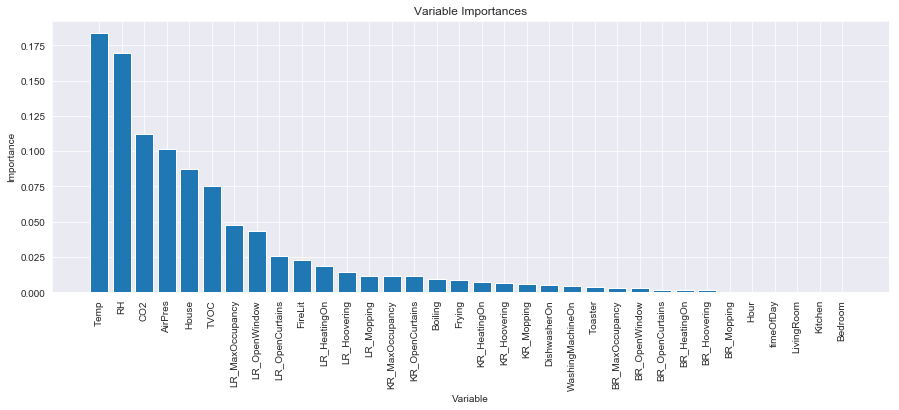

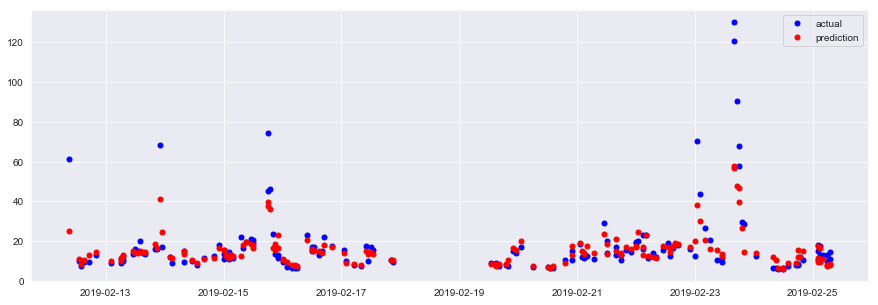

In [85]:
basic_rf(H)


Training Features Shape: (648, 34)
Training Labels Shape: (648,)
Testing Features Shape: (162, 34)
Testing Labels Shape: (162,) 

MAE baseline error: Mean of PM2.5 - 9.36 degrees.
MAE: 5.88 degrees.
MAE Improvement over baseline: 37.23 %
MAPE Accuracy: 71.91 %.

RMSE: 13.21716802437664
Feature: AirPres              Weight: 0.138
Feature: Temp                 Weight: 0.108
Feature: CO2                  Weight: 0.07
Feature: RH                   Weight: 0.031
Feature: House                Weight: 0.001


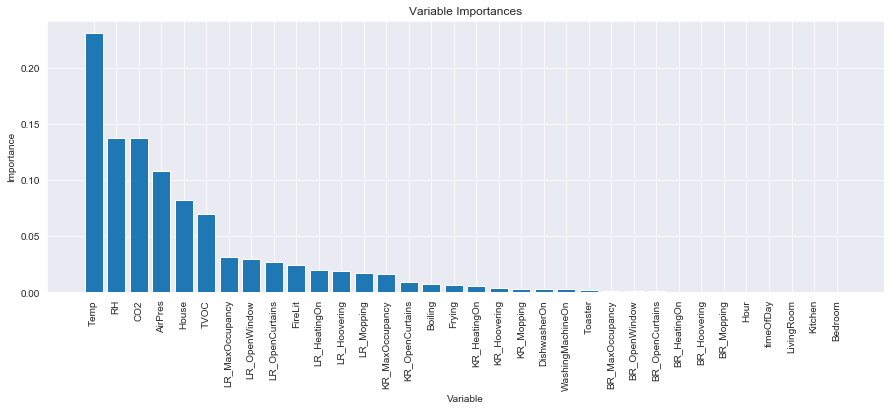

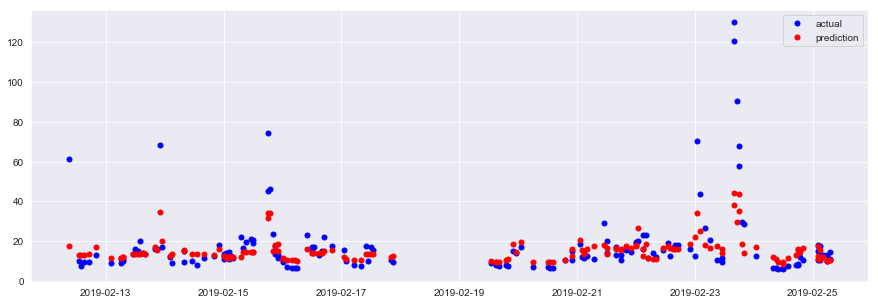

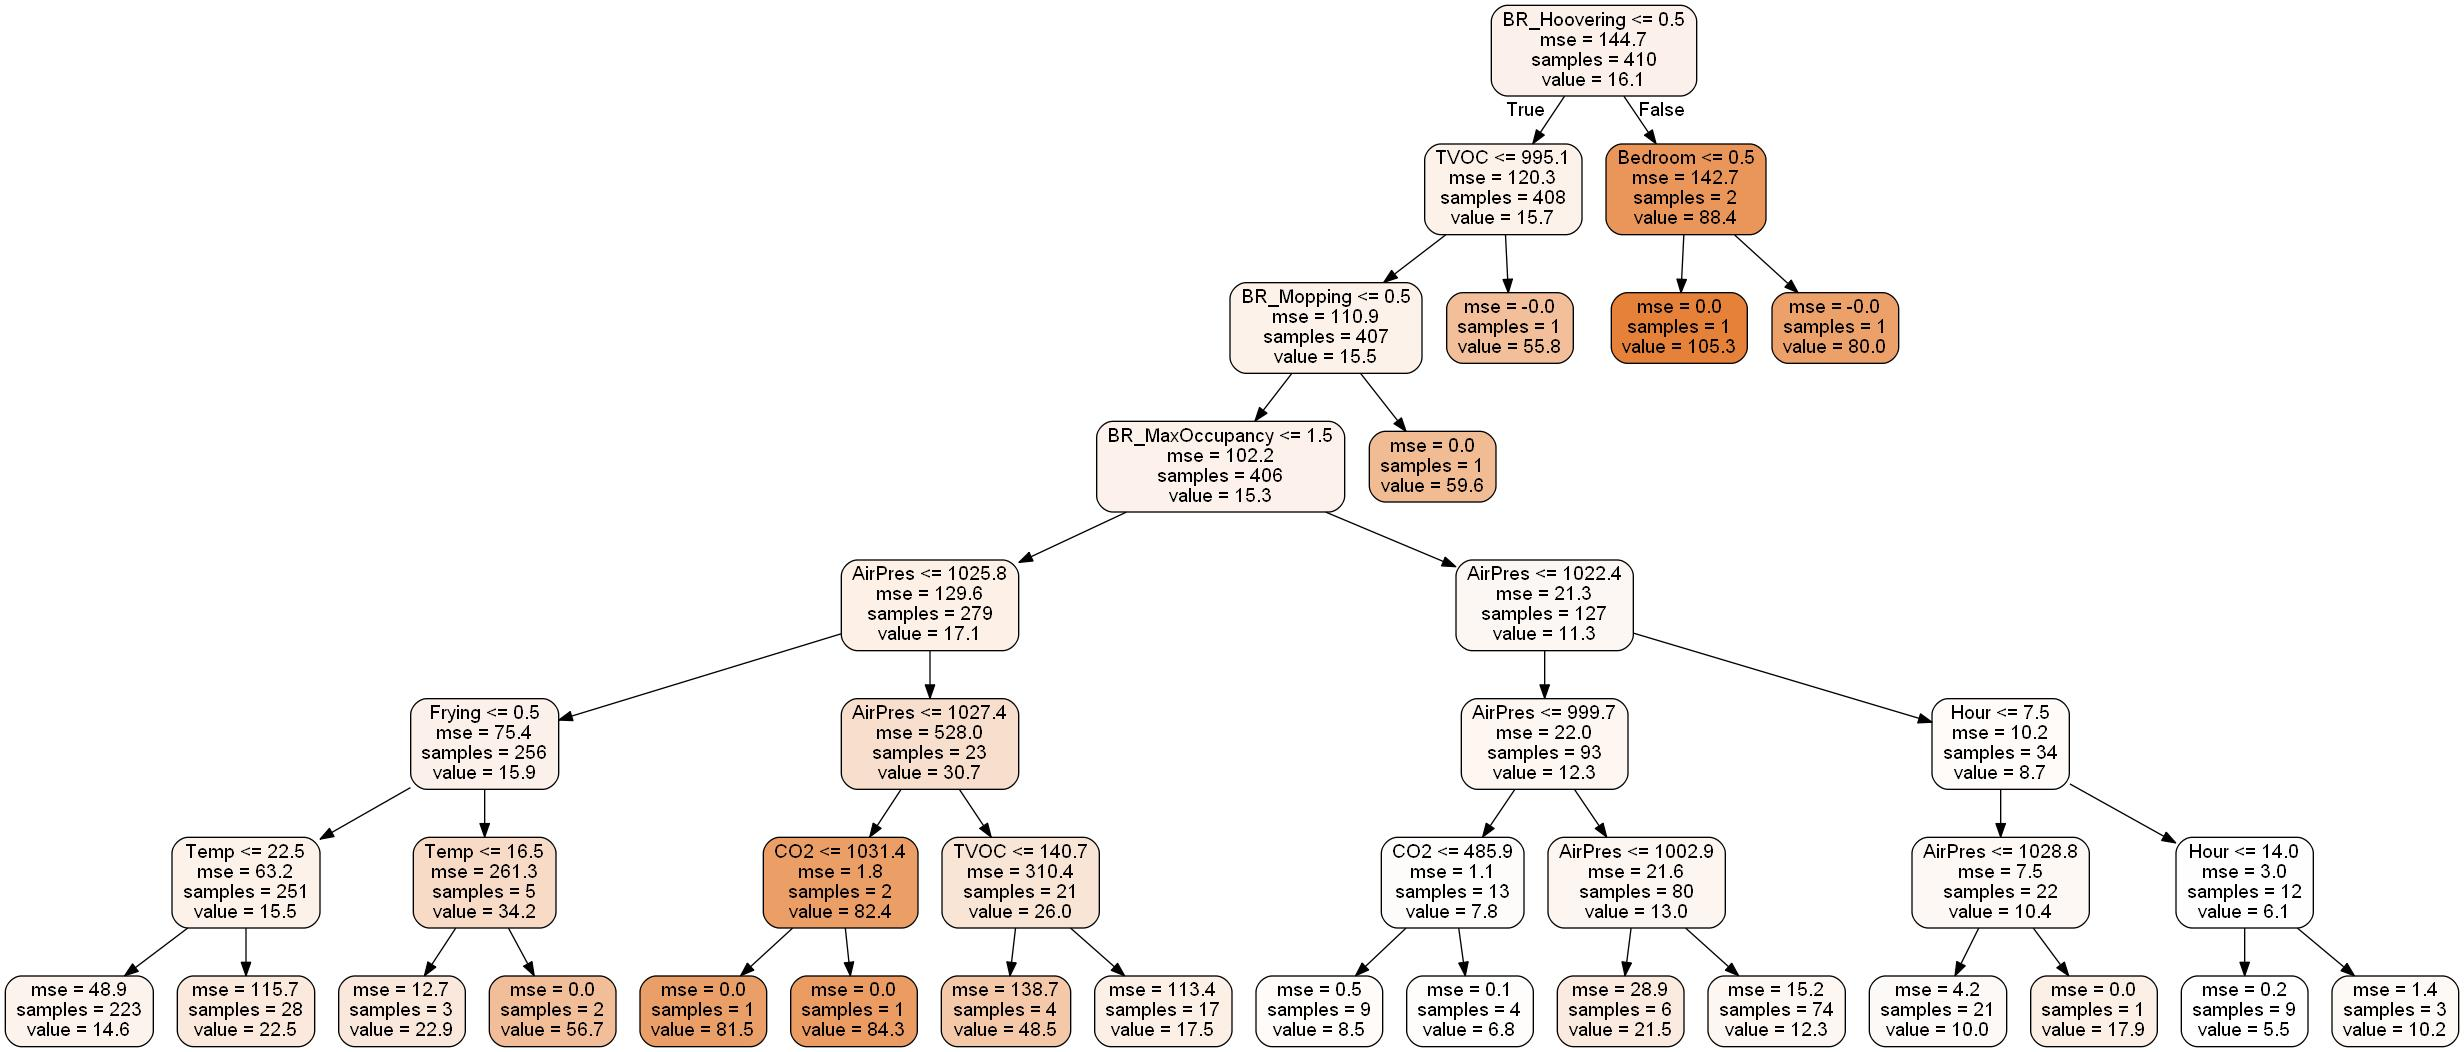

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [86]:
tuned_rf(H)

Training Features Shape: (314, 34)
Training Labels Shape: (314,)
Testing Features Shape: (79, 34)
Testing Labels Shape: (79,) 

MAE baseline error: Mean of PM2.5 - 6.11 degrees.
MAE: 3.3 degrees.
MAE Improvement over baseline: 45.93 %
MAPE Accuracy: 79.47 %.

RMSE: 5.731859750584569
Feature: AirPres              Weight: 0.124
Feature: CO2                  Weight: 0.119
Feature: Temp                 Weight: 0.064
Feature: RH                   Weight: 0.045
Feature: House                Weight: 0.0


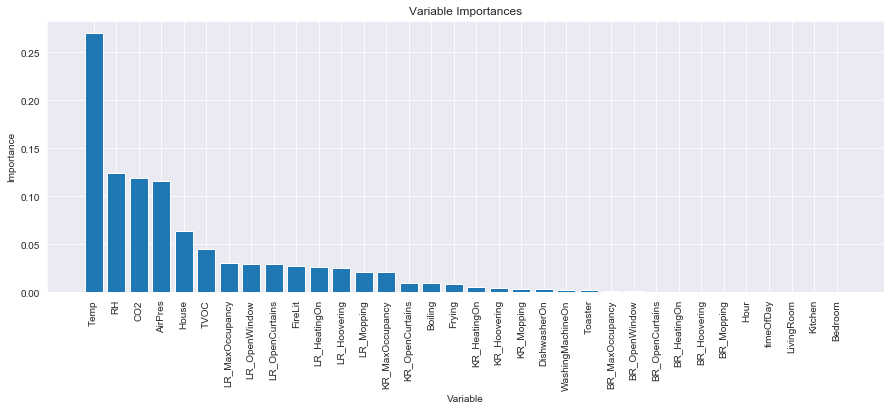

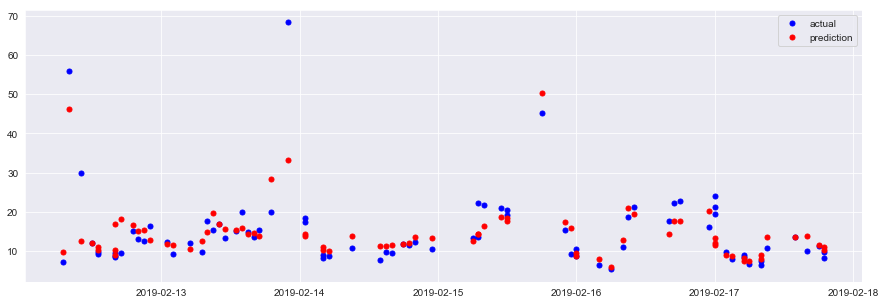

In [87]:
basic_rf(H1)

Training Features Shape: (314, 34)
Training Labels Shape: (314,)
Testing Features Shape: (79, 34)
Testing Labels Shape: (79,) 

MAE baseline error: Mean of PM2.5 - 6.11 degrees.
MAE: 4.43 degrees.
MAE Improvement over baseline: 27.46 %
MAPE Accuracy: 69.91 %.

RMSE: 6.767149215906832
Feature: AirPres              Weight: 0.107
Feature: CO2                  Weight: 0.089
Feature: RH                   Weight: 0.051
Feature: Temp                 Weight: 0.047
Feature: House                Weight: 0.0


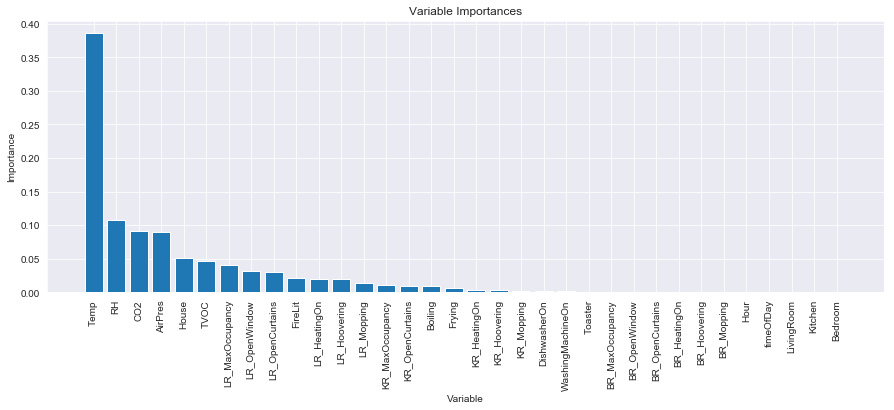

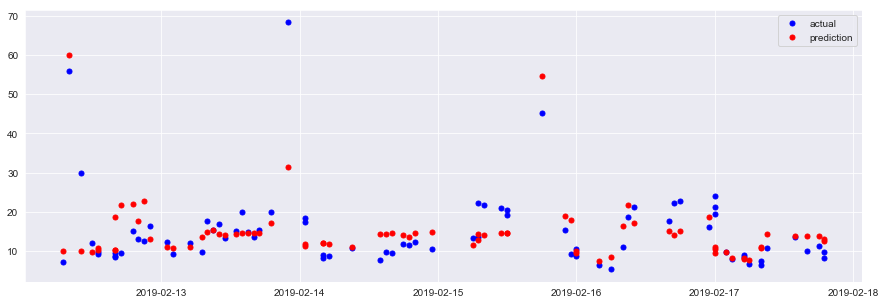

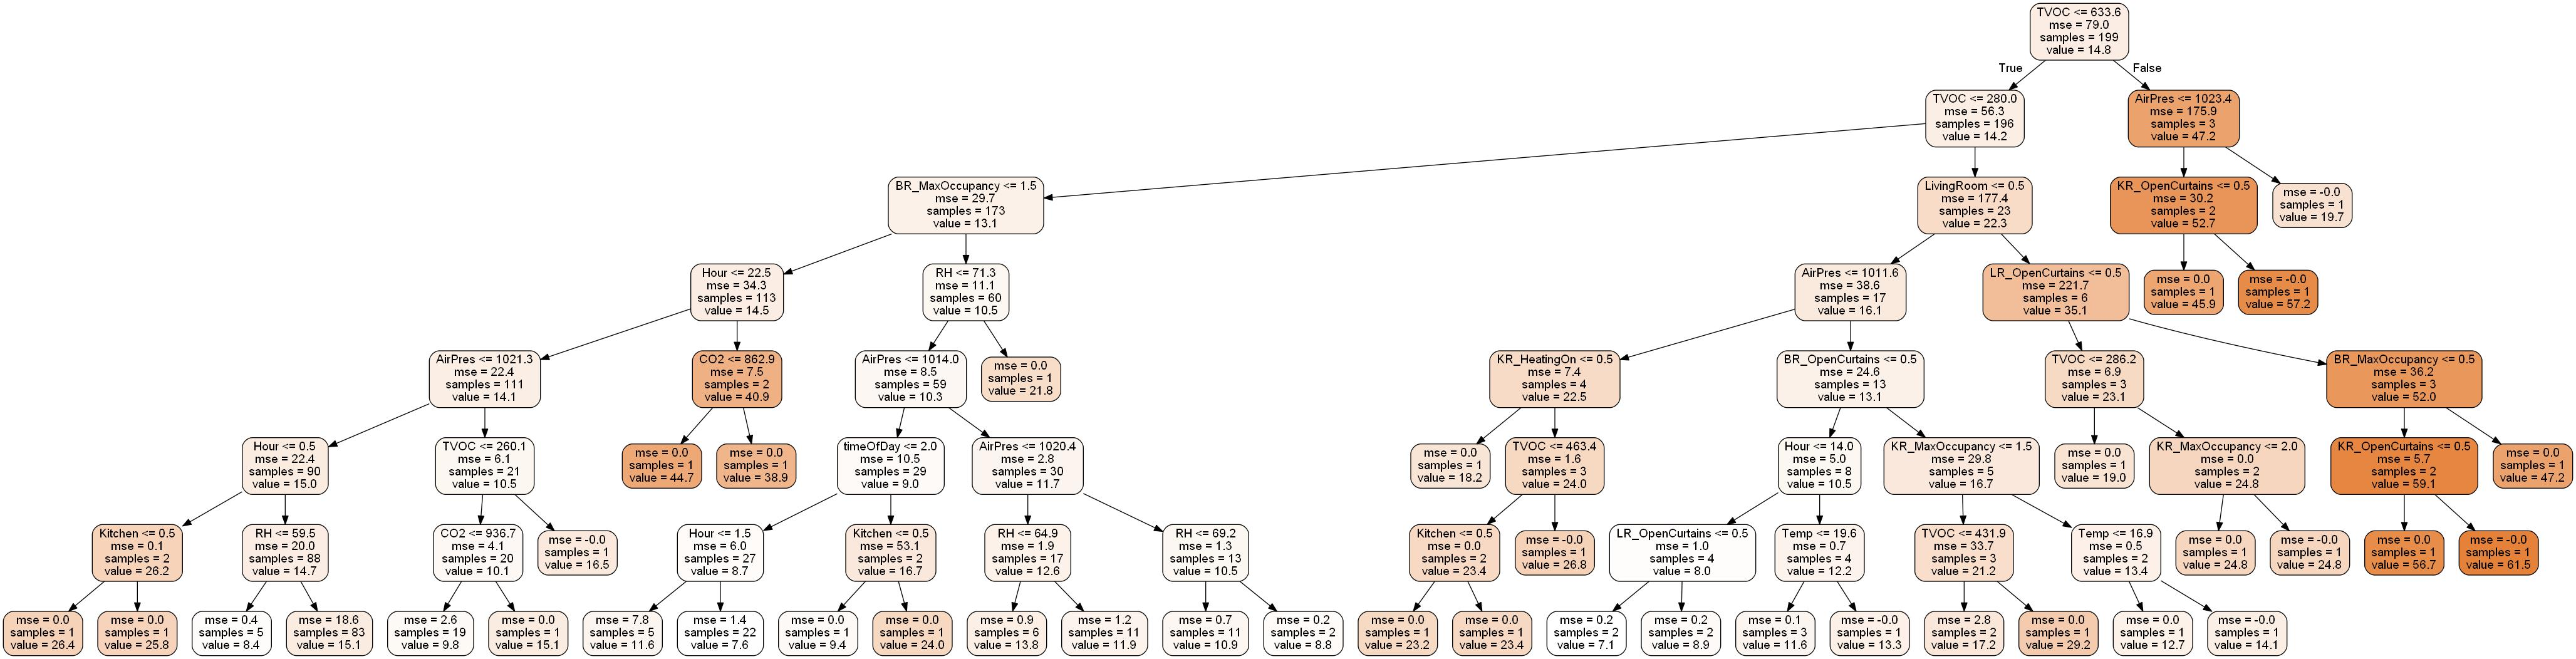

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [88]:
tuned_rf(H1)

Training Features Shape: (333, 38)
Training Labels Shape: (333,)
Testing Features Shape: (84, 38)
Testing Labels Shape: (84,) 

MAE baseline error: Mean of PM2.5 - 9.86 degrees.
MAE: 4.07 degrees.
MAE Improvement over baseline: 58.7 %
MAPE Accuracy: 74.69 %.

RMSE: 6.827557219378913
Feature: AirPres              Weight: 0.143
Feature: Temp                 Weight: 0.106
Feature: CO2                  Weight: 0.071
Feature: RH                   Weight: 0.05
Feature: House                Weight: 0.0


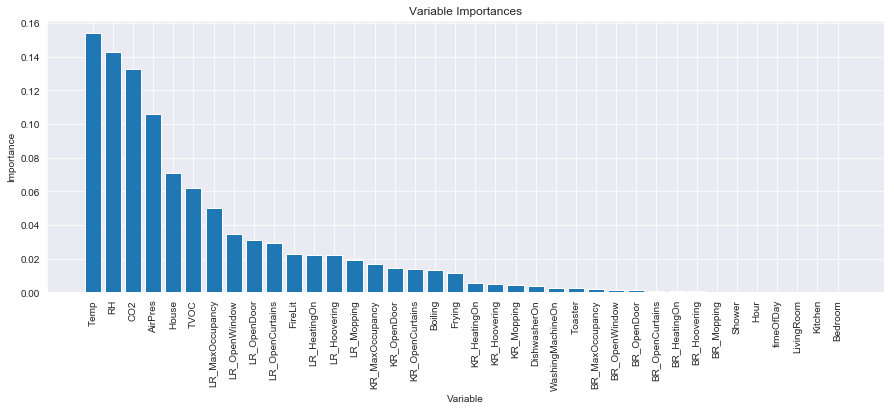

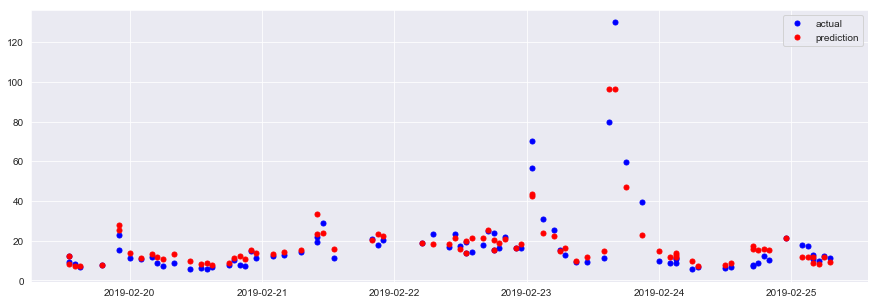

In [89]:
basic_rf(H2)

Training Features Shape: (333, 38)
Training Labels Shape: (333,)
Testing Features Shape: (84, 38)
Testing Labels Shape: (84,) 

MAE baseline error: Mean of PM2.5 - 9.86 degrees.
MAE: 4.72 degrees.
MAE Improvement over baseline: 52.14 %
MAPE Accuracy: 68.99 %.

RMSE: 7.709001943170199
Feature: AirPres              Weight: 0.122
Feature: Temp                 Weight: 0.094
Feature: CO2                  Weight: 0.064
Feature: RH                   Weight: 0.034
Feature: House                Weight: 0.0


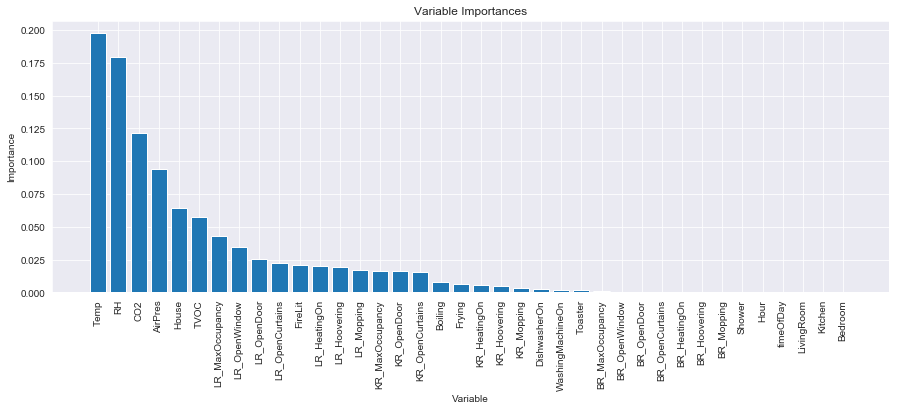

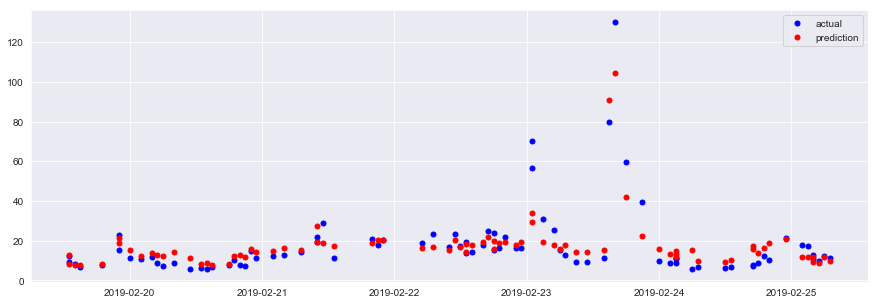

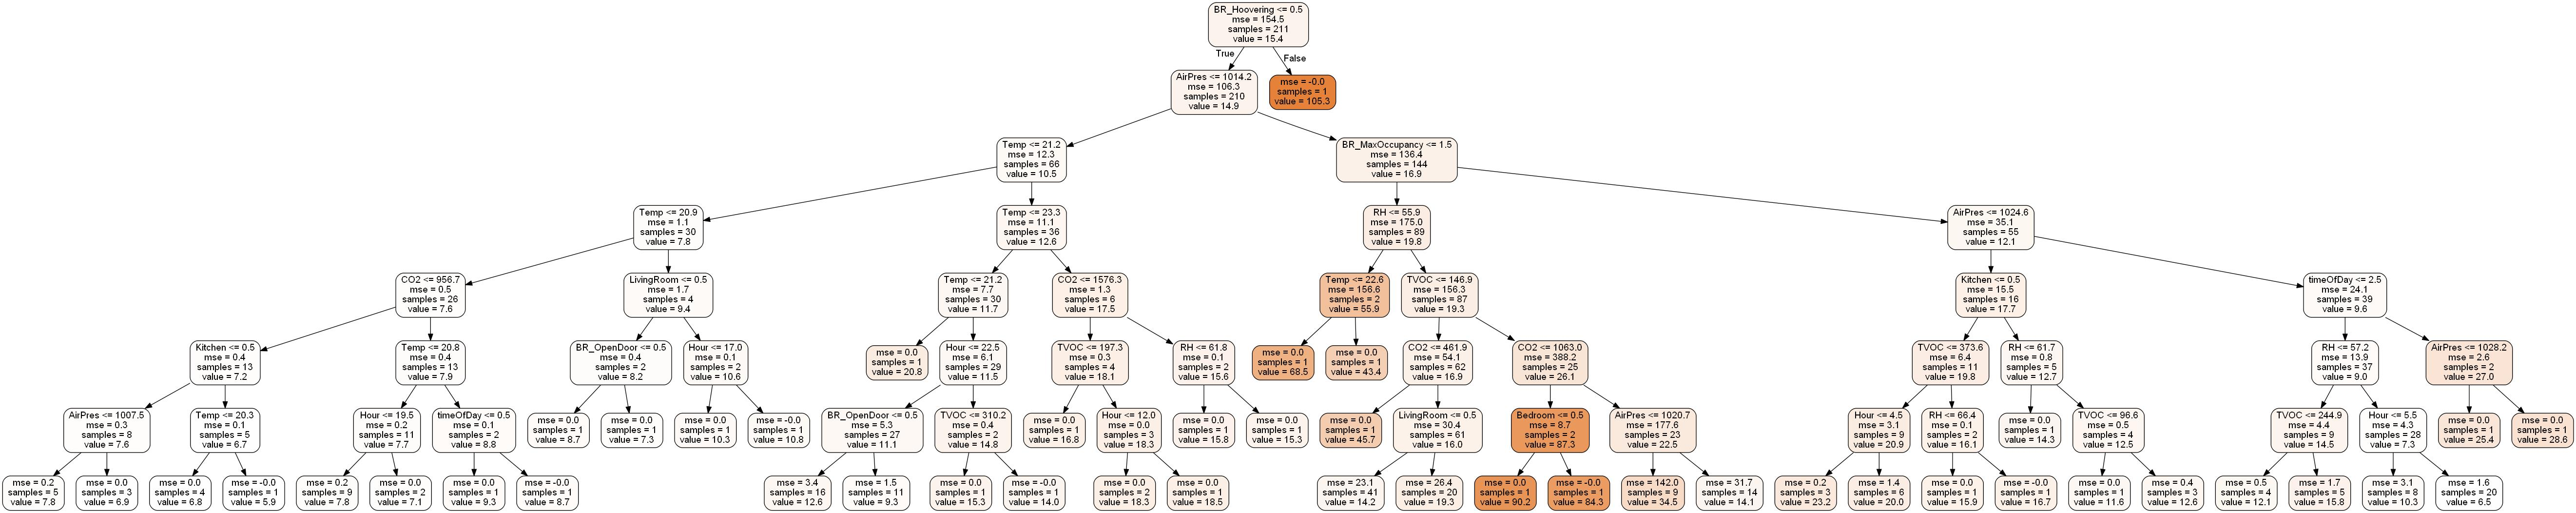

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [90]:
tuned_rf(H2)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 7.04 degrees.
MAE: 4.29 degrees.
MAE Improvement over baseline: 39.15 %
MAPE Accuracy: 72.46 %.

RMSE: 6.73955399301874
Feature: Temp                 Weight: 0.201
Feature: AirPres              Weight: 0.094
Feature: RH                   Weight: 0.073
Feature: CO2                  Weight: 0.048
Feature: House                Weight: 0.008


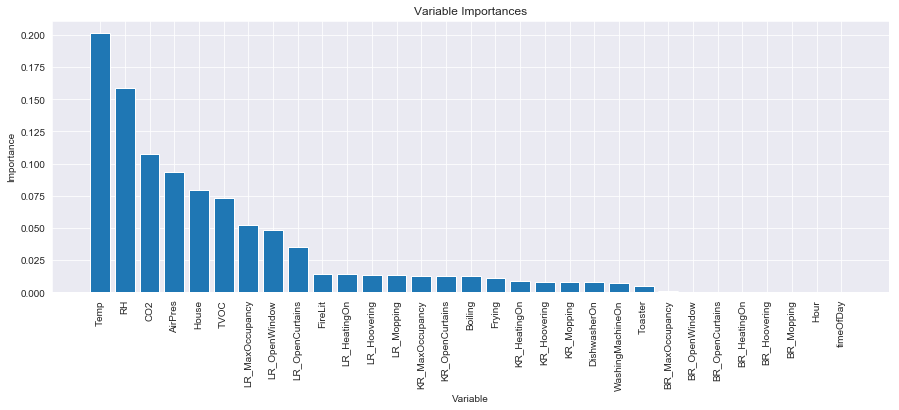

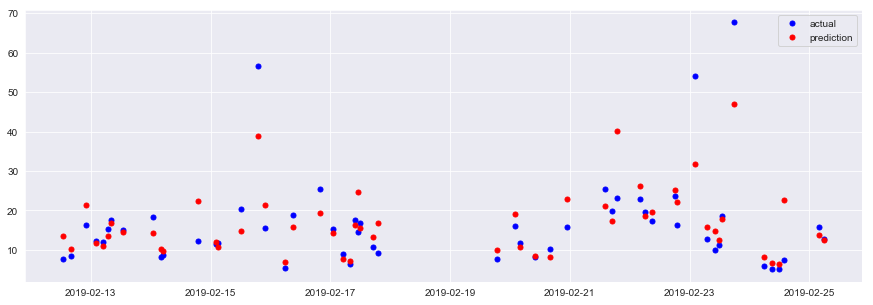

In [91]:
basic_rf(LR)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 7.04 degrees.
MAE: 4.66 degrees.
MAE Improvement over baseline: 33.82 %
MAPE Accuracy: 67.67 %.

RMSE: 6.749937234516456
Feature: Temp                 Weight: 0.184
Feature: AirPres              Weight: 0.111
Feature: RH                   Weight: 0.065
Feature: CO2                  Weight: 0.041
Feature: House                Weight: 0.011


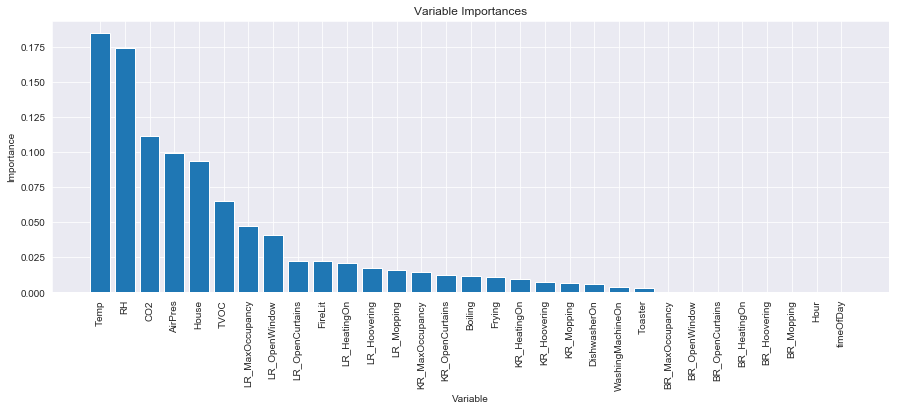

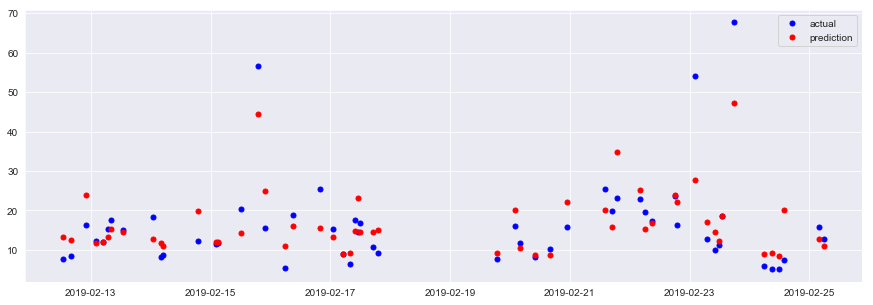

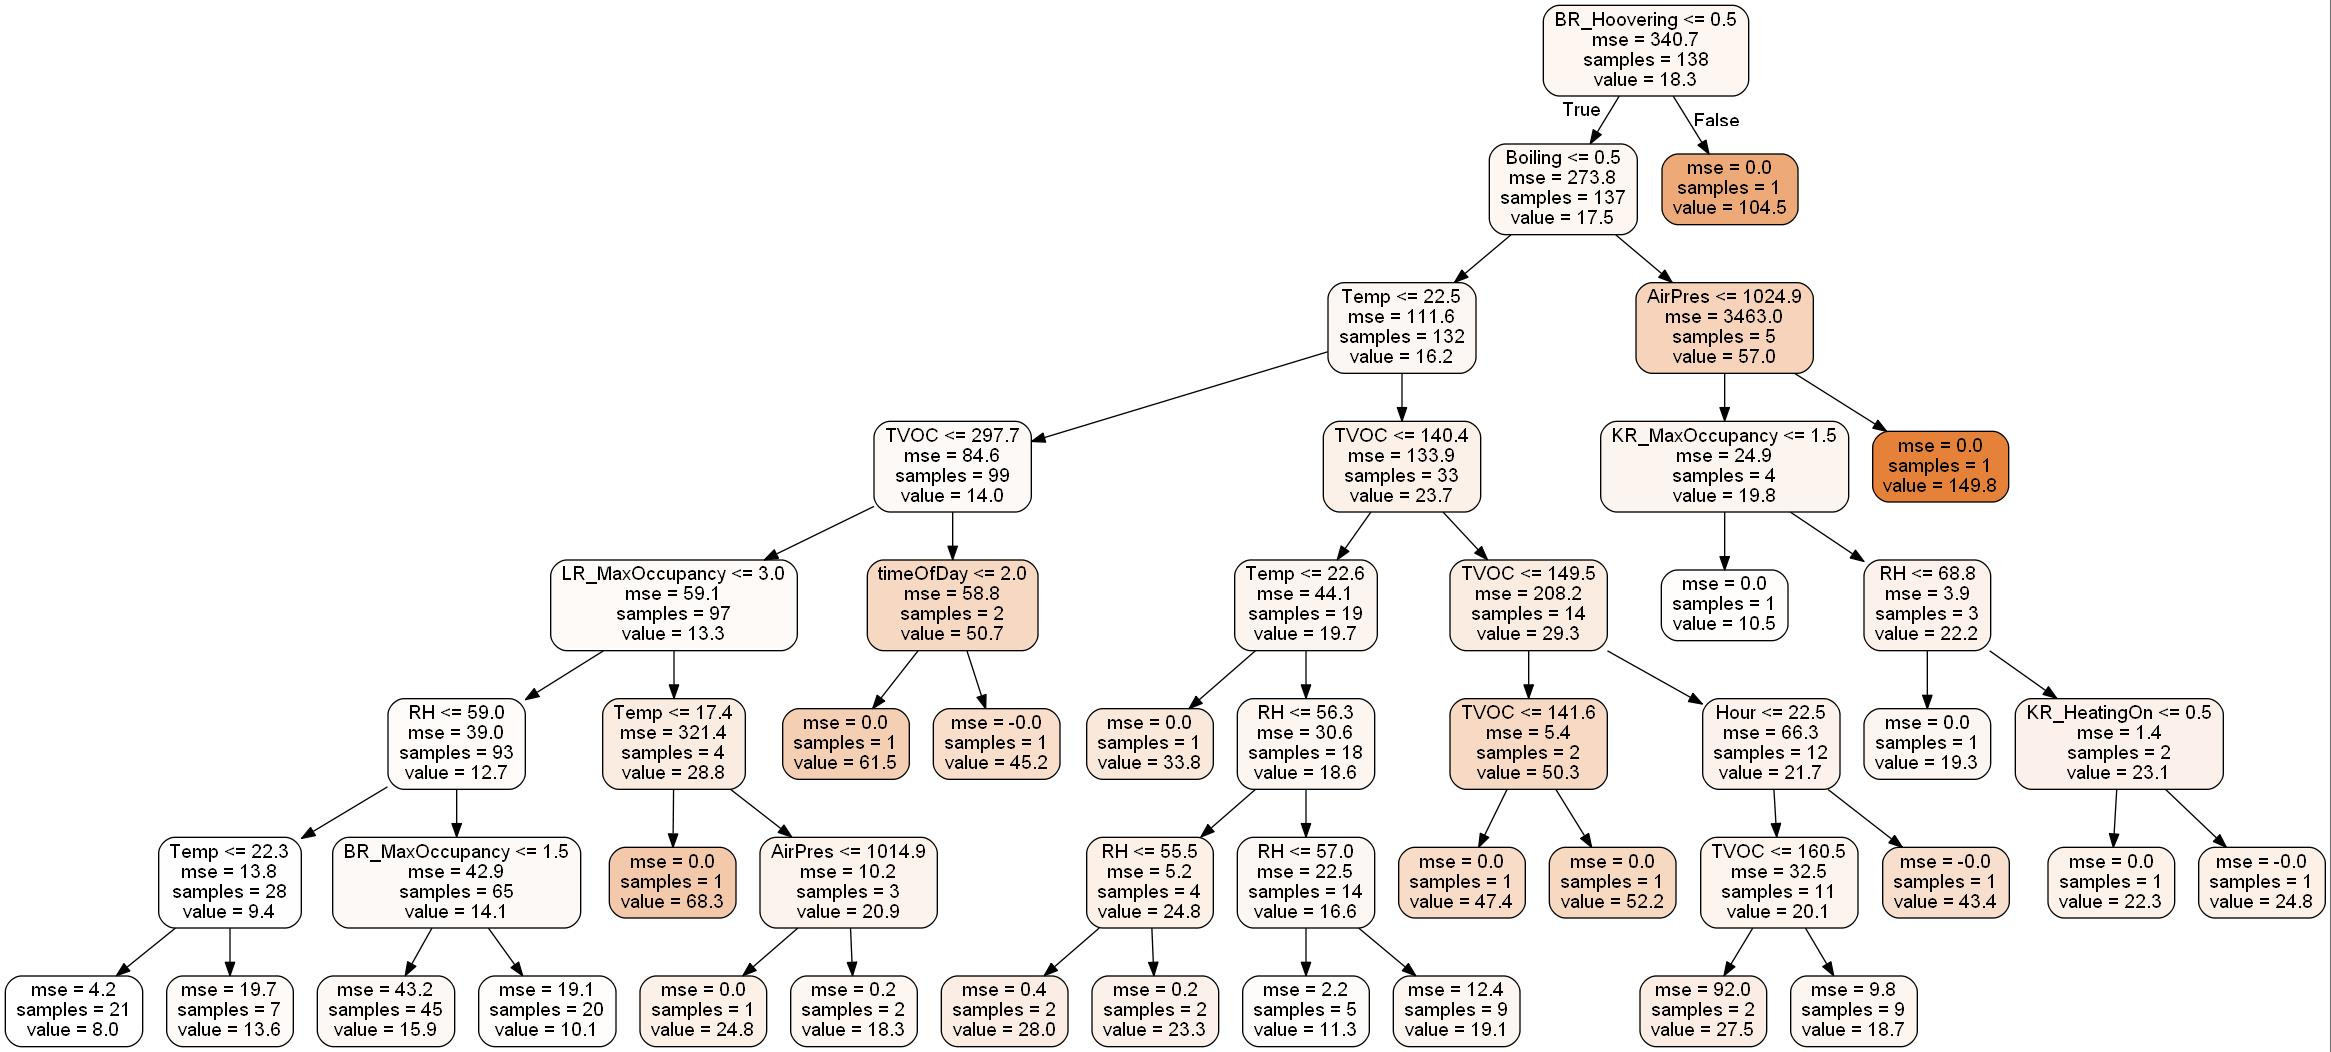

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [92]:
tuned_rf(LR)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 5.65 degrees.
MAE: 3.97 degrees.
MAE Improvement over baseline: 29.77 %
MAPE Accuracy: 71.45 %.

RMSE: 6.66907096222999
Feature: AirPres              Weight: 0.119
Feature: Temp                 Weight: 0.114
Feature: RH                   Weight: 0.104
Feature: CO2                  Weight: 0.049
Feature: House                Weight: 0.015


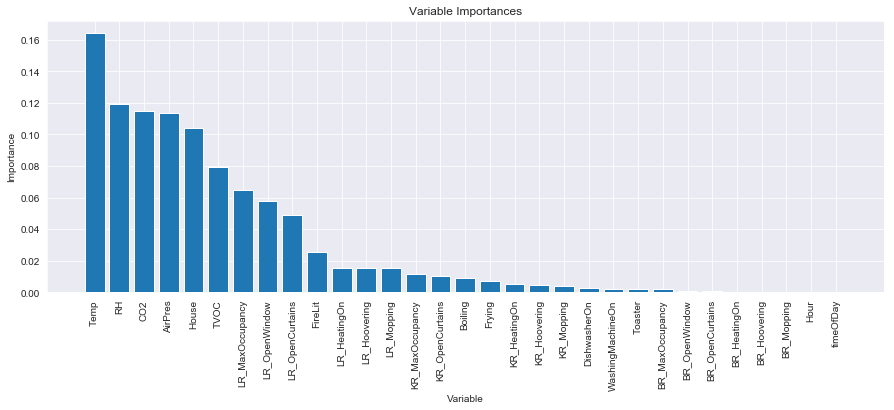

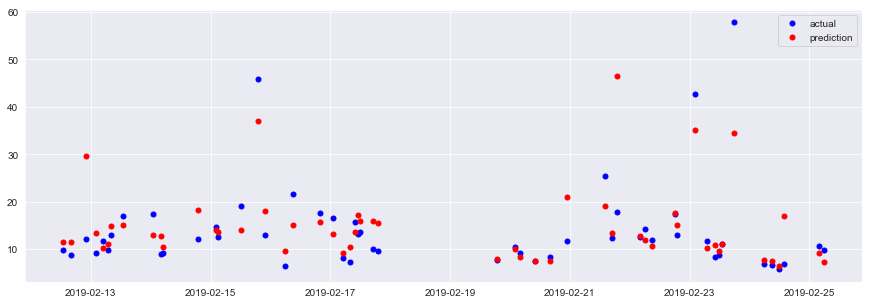

In [93]:
basic_rf(KR)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 5.65 degrees.
MAE: 4.41 degrees.
MAE Improvement over baseline: 21.9 %
MAPE Accuracy: 66.5 %.

RMSE: 7.47568685208981
Feature: AirPres              Weight: 0.137
Feature: Temp                 Weight: 0.091
Feature: RH                   Weight: 0.078
Feature: House                Weight: 0.037
Feature: CO2                  Weight: 0.017


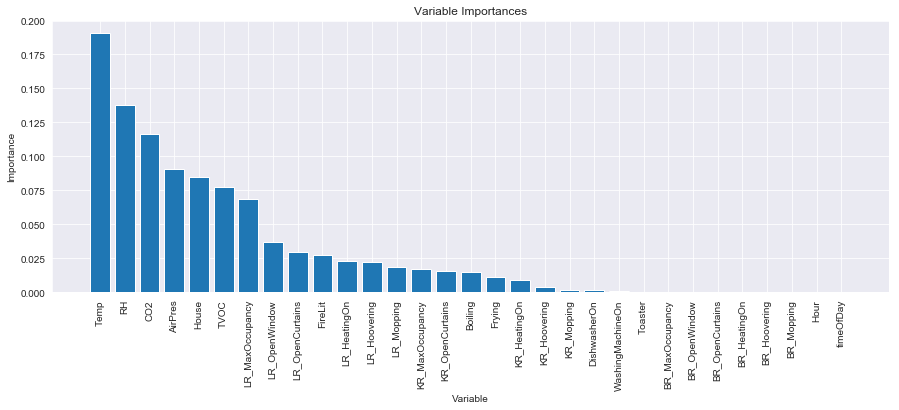

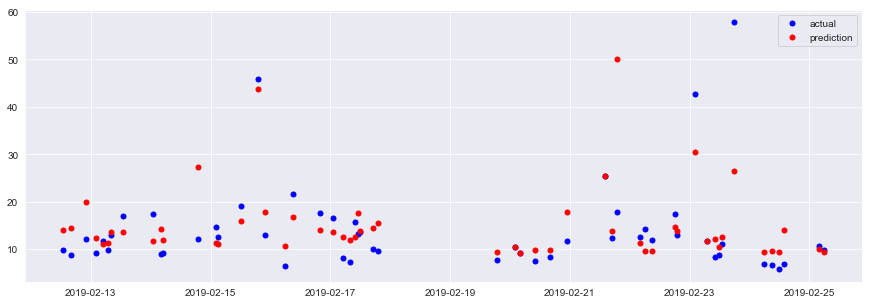

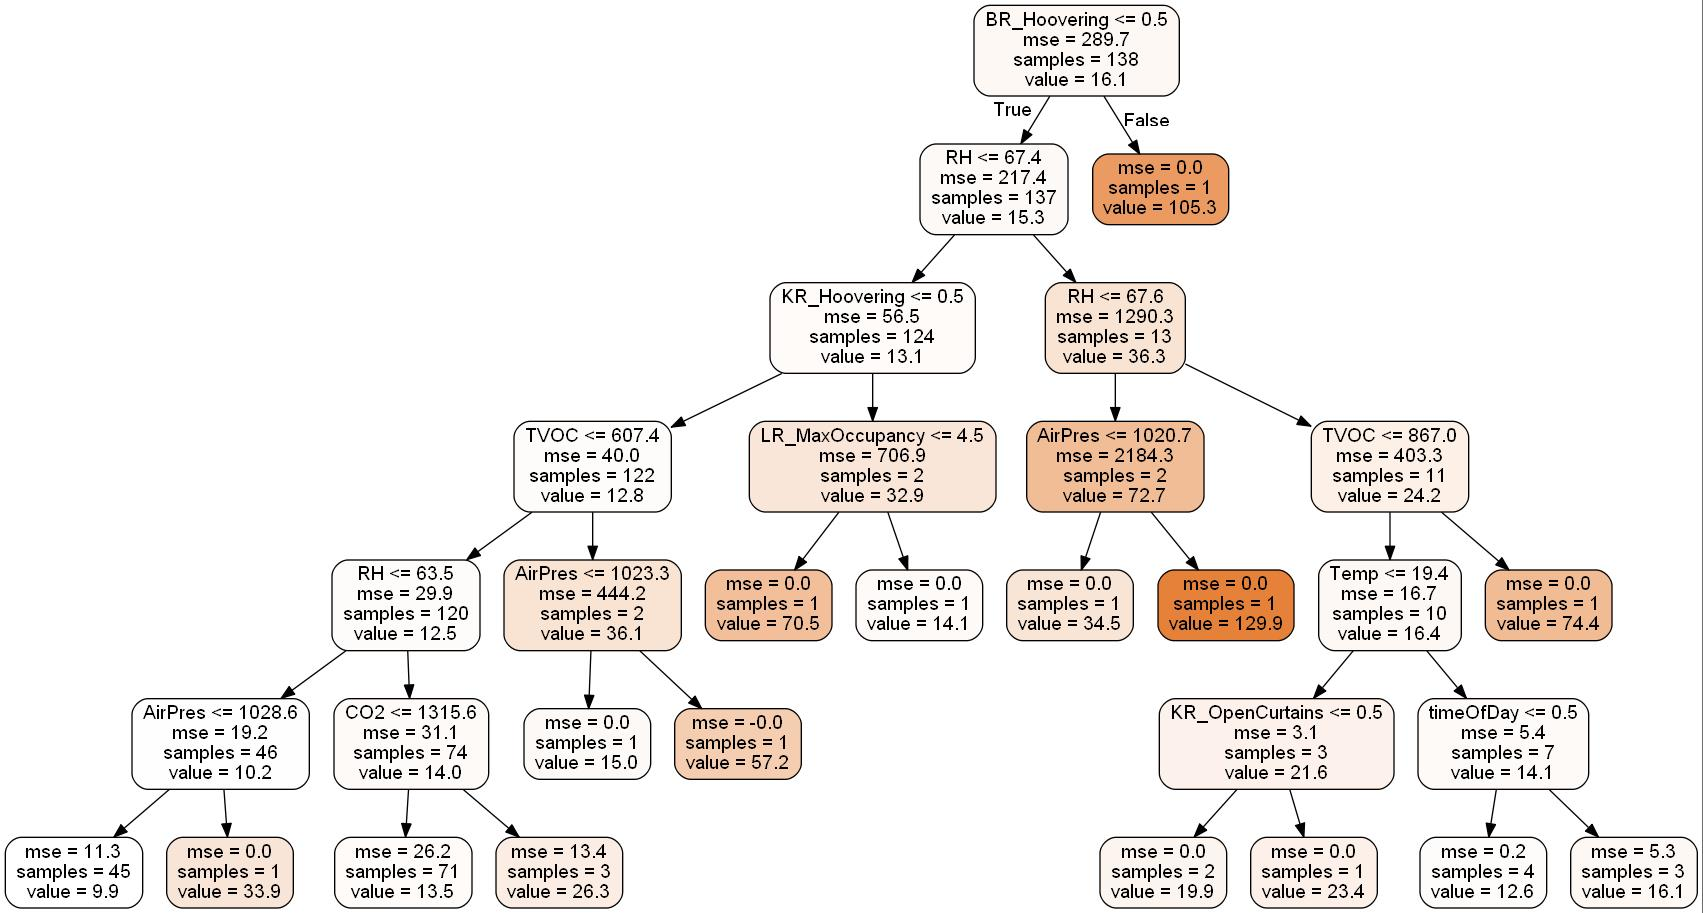

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [94]:
tuned_rf(KR)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 5.49 degrees.
MAE: 4.3 degrees.
MAE Improvement over baseline: 21.59 %
MAPE Accuracy: 72.09 %.

RMSE: 8.941346980574965
Feature: RH                   Weight: 0.12
Feature: AirPres              Weight: 0.118
Feature: CO2                  Weight: 0.11
Feature: Temp                 Weight: 0.095
Feature: House                Weight: 0.017


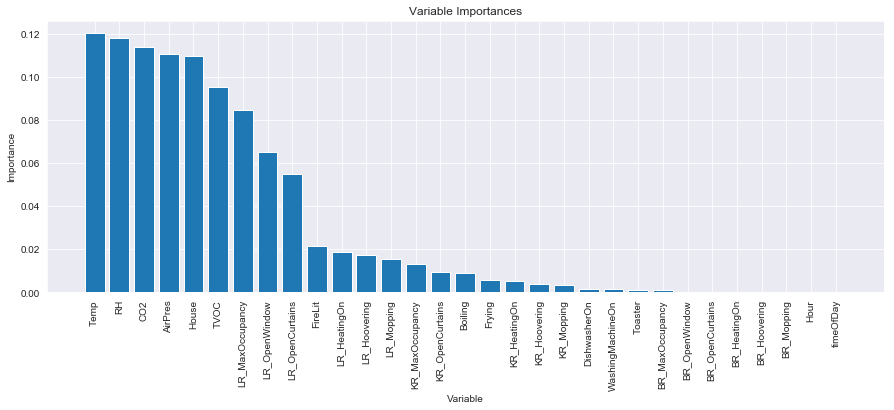

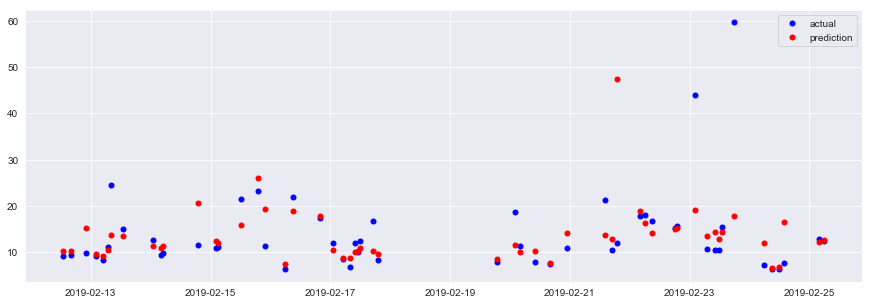

In [95]:
basic_rf(BR)

Training Features Shape: (216, 31)
Training Labels Shape: (216,)
Testing Features Shape: (54, 31)
Testing Labels Shape: (54,) 

MAE baseline error: Mean of PM2.5 - 5.49 degrees.
MAE: 4.91 degrees.
MAE Improvement over baseline: 10.54 %
MAPE Accuracy: 66.58 %.

RMSE: 10.83185617435677
Feature: AirPres              Weight: 0.174
Feature: CO2                  Weight: 0.126
Feature: RH                   Weight: 0.117
Feature: Temp                 Weight: 0.095
Feature: House                Weight: 0.029


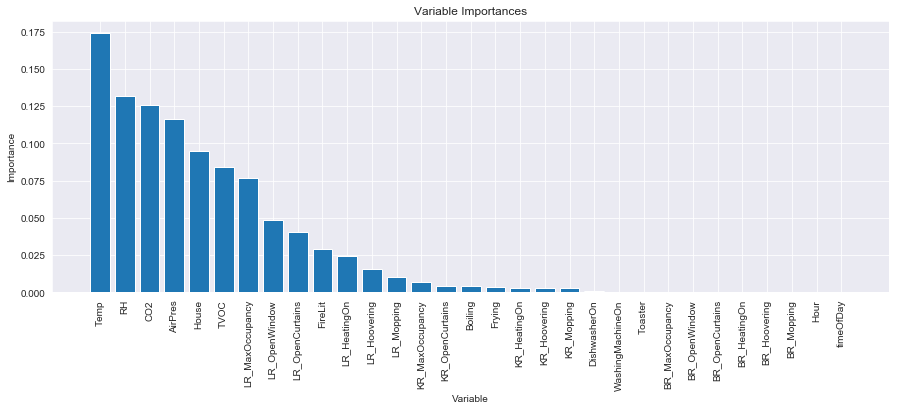

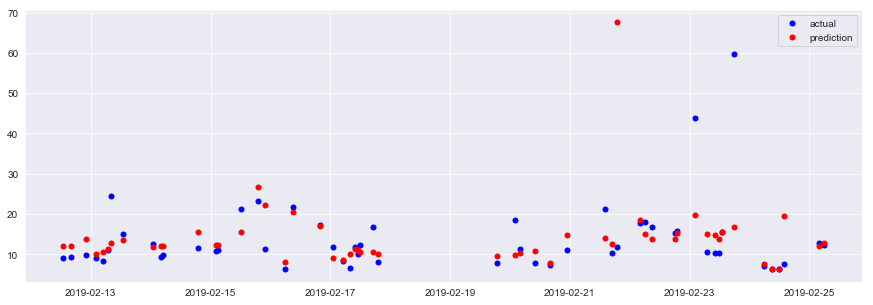

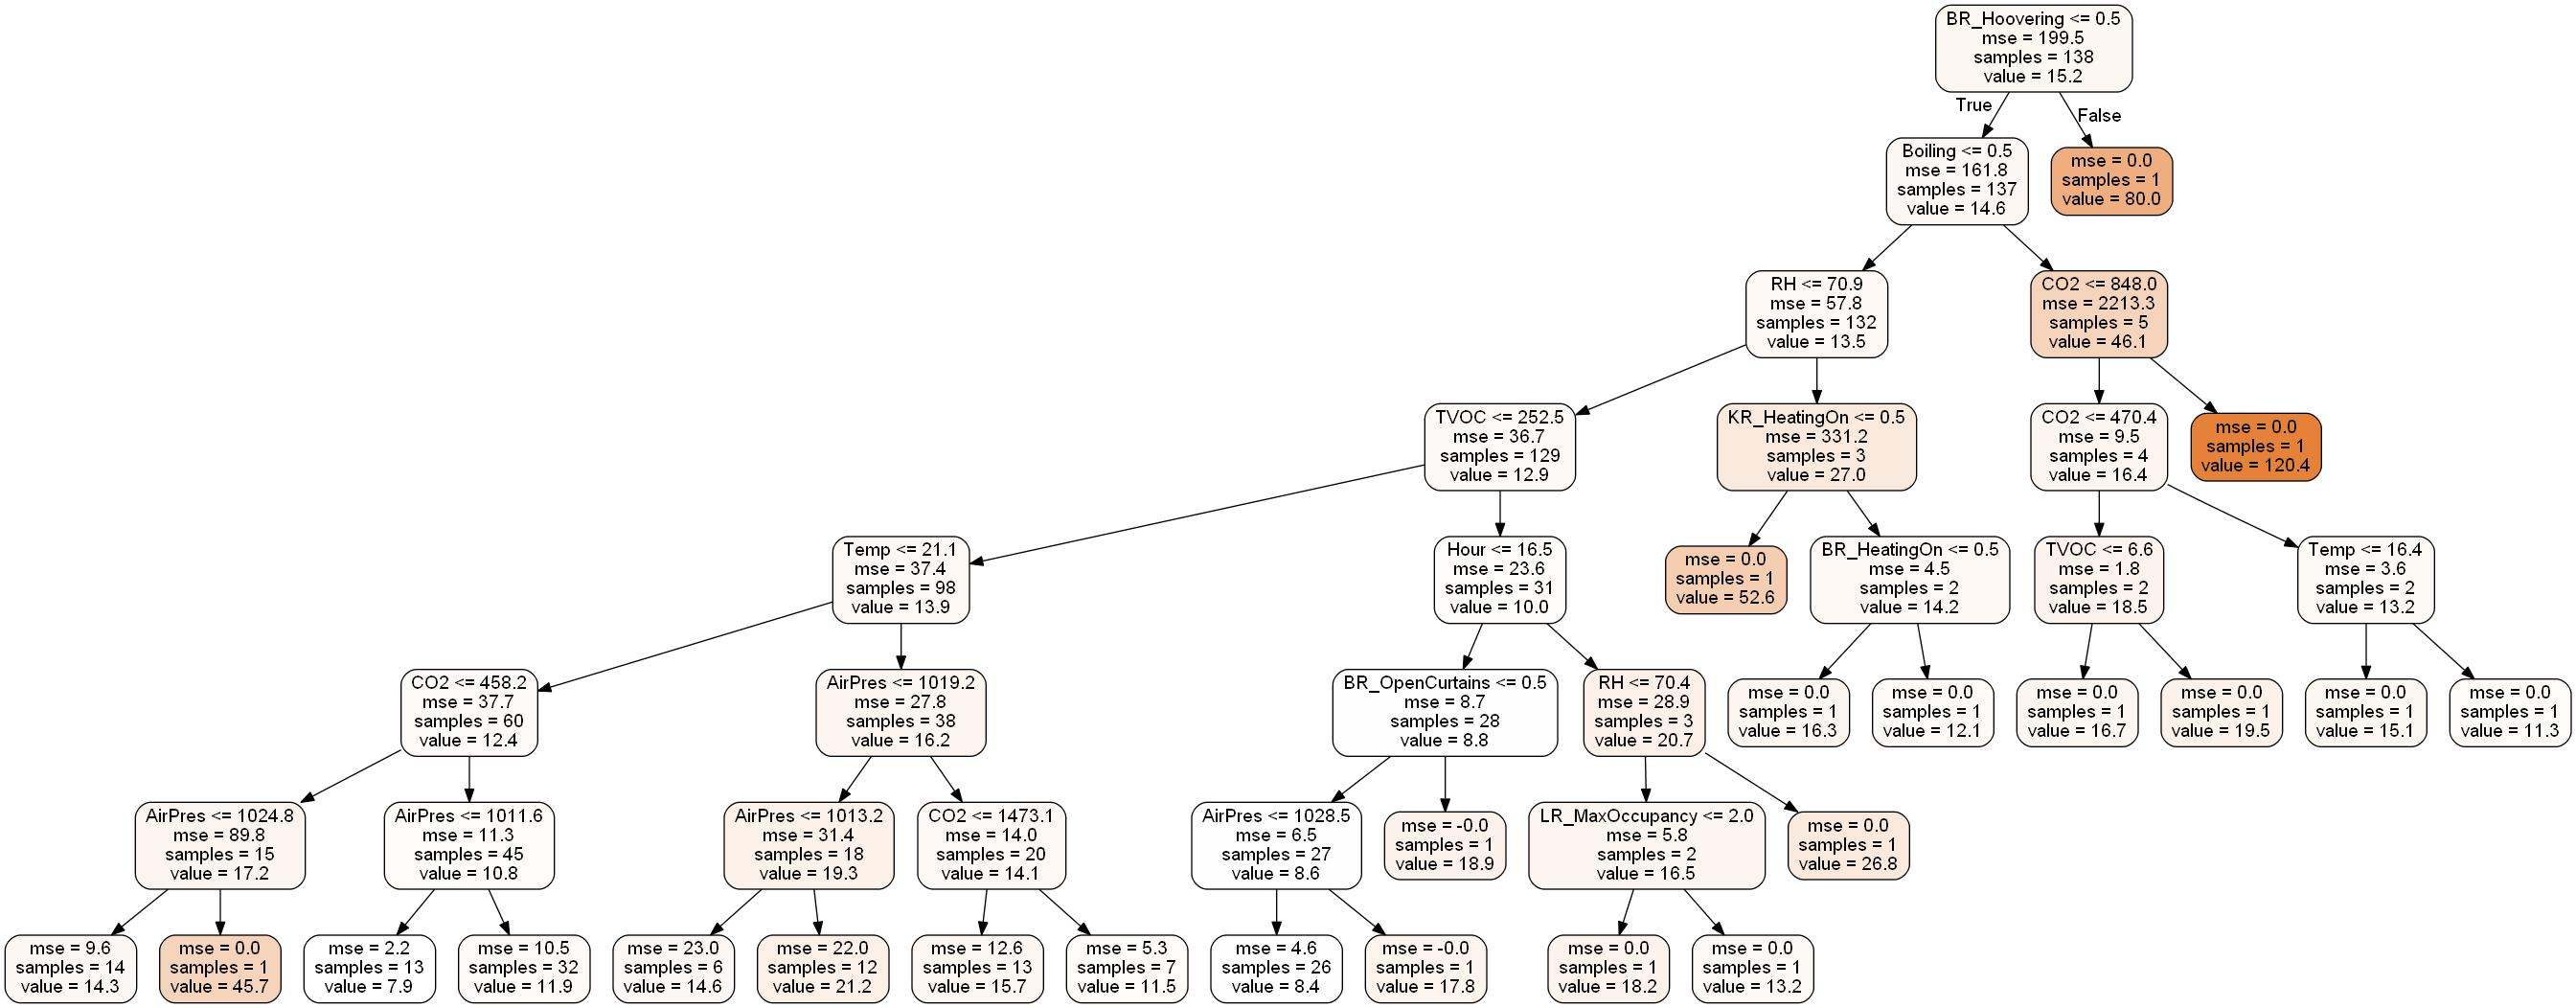

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [96]:
tuned_rf(BR)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 5.2 degrees.
MAE: 3.86 degrees.
MAE Improvement over baseline: 25.75 %
MAPE Accuracy: 75.53 %.

RMSE: 6.8958916434996915
Feature: CO2                  Weight: 0.124
Feature: Temp                 Weight: 0.089
Feature: AirPres              Weight: 0.06
Feature: RH                   Weight: 0.058
Feature: House                Weight: 0.0


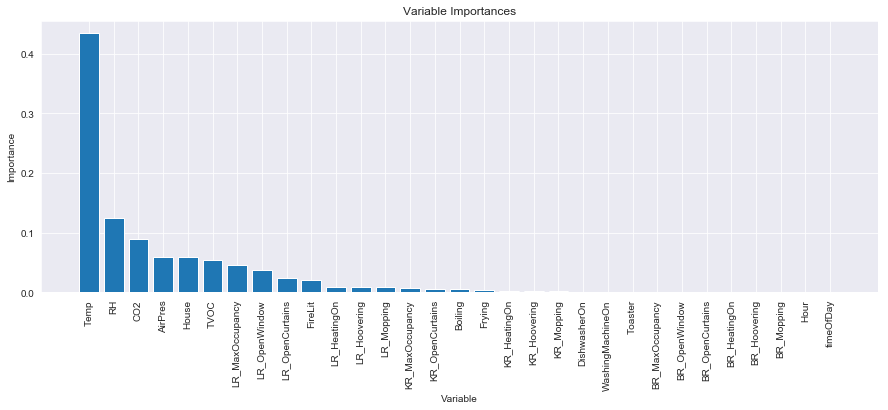

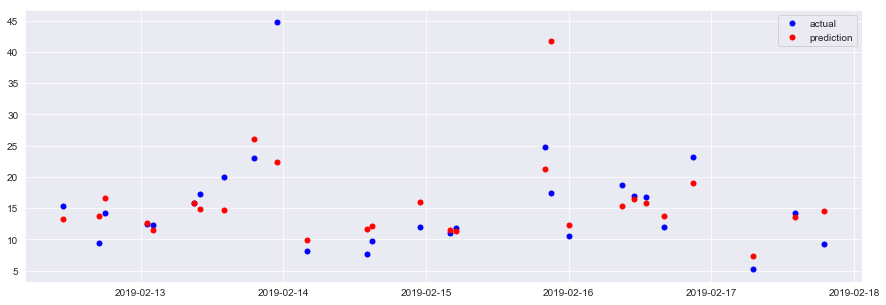

In [97]:
basic_rf(LR1)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 5.2 degrees.
MAE: 3.96 degrees.
MAE Improvement over baseline: 23.87 %
MAPE Accuracy: 73.88 %.

RMSE: 7.2776847721927
Feature: CO2                  Weight: 0.132
Feature: Temp                 Weight: 0.112
Feature: RH                   Weight: 0.029
Feature: AirPres              Weight: 0.029
Feature: House                Weight: 0.0


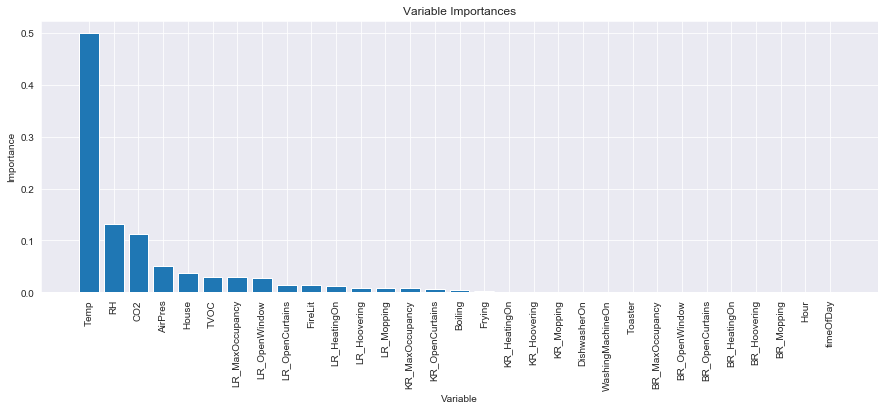

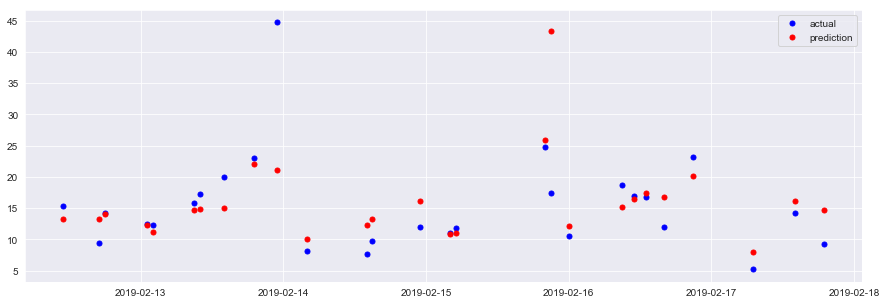

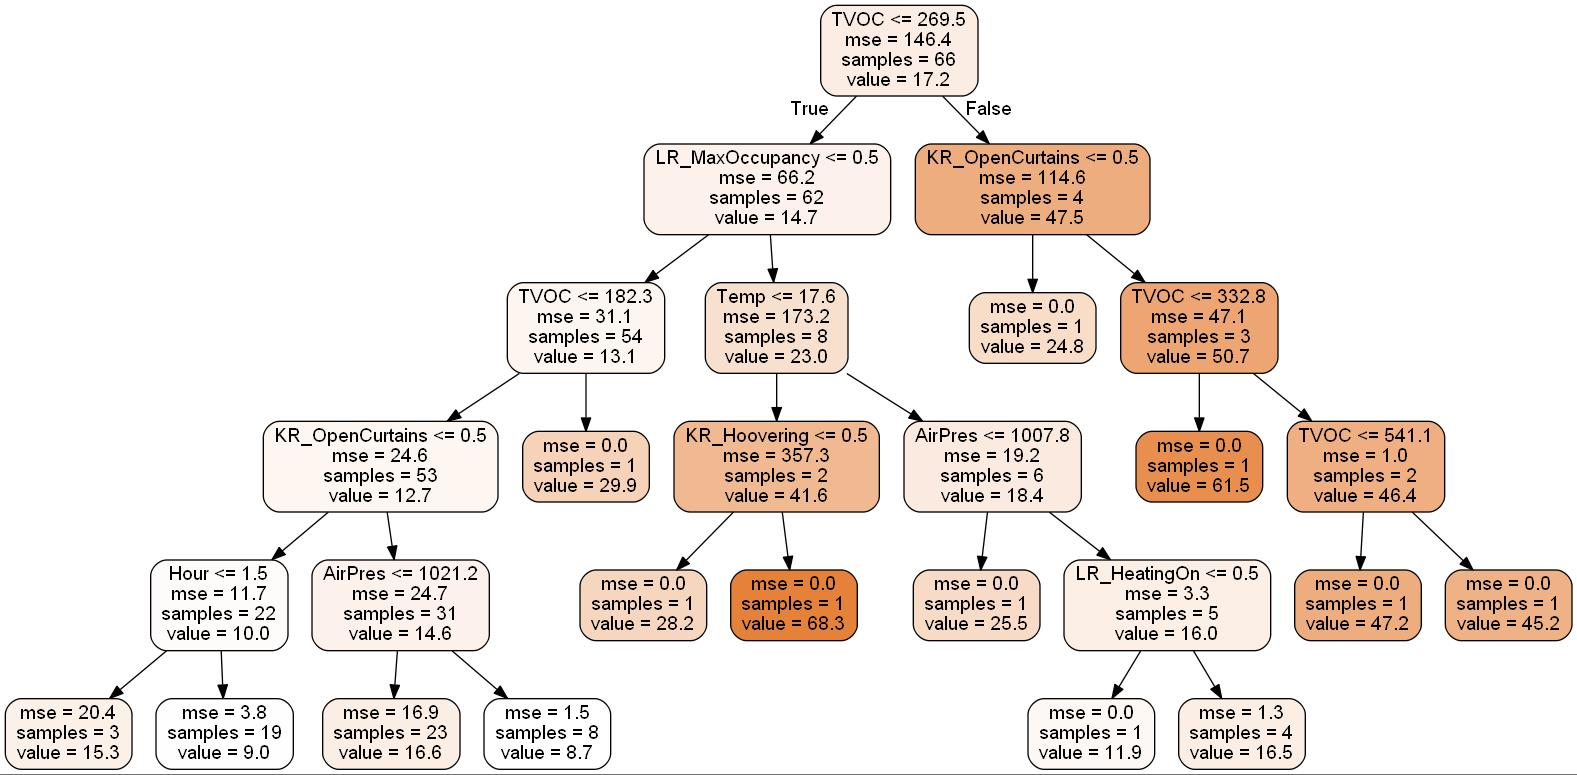

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [98]:
tuned_rf(LR1)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 6.01 degrees.
MAE: 3.93 degrees.
MAE Improvement over baseline: 34.6 %
MAPE Accuracy: 75.86 %.

RMSE: 6.153023912301752
Feature: Temp                 Weight: 0.218
Feature: AirPres              Weight: 0.064
Feature: RH                   Weight: 0.056
Feature: CO2                  Weight: 0.031
Feature: House                Weight: 0.0


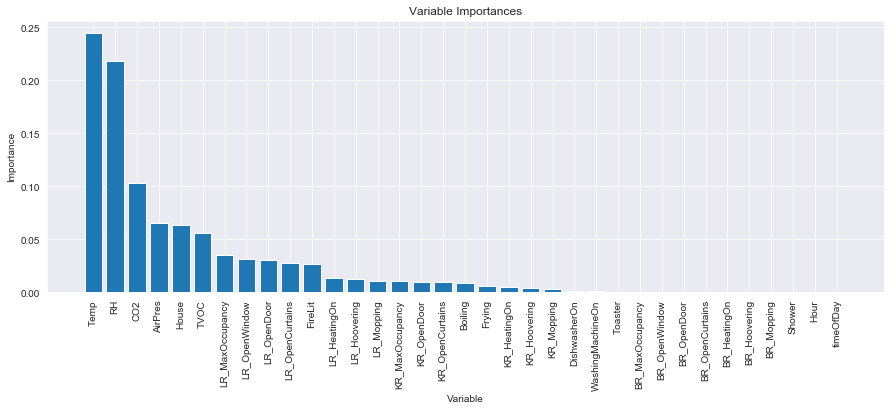

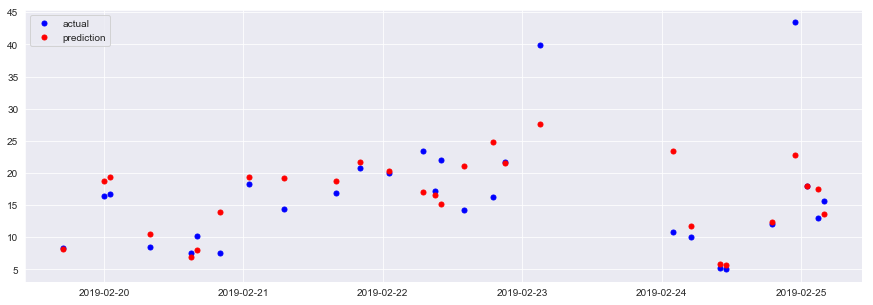

In [99]:
basic_rf(LR2)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 6.01 degrees.
MAE: 5.08 degrees.
MAE Improvement over baseline: 15.44 %
MAPE Accuracy: 64.84 %.

RMSE: 6.983273820393248
Feature: Temp                 Weight: 0.253
Feature: AirPres              Weight: 0.081
Feature: RH                   Weight: 0.057
Feature: CO2                  Weight: 0.015
Feature: House                Weight: 0.0


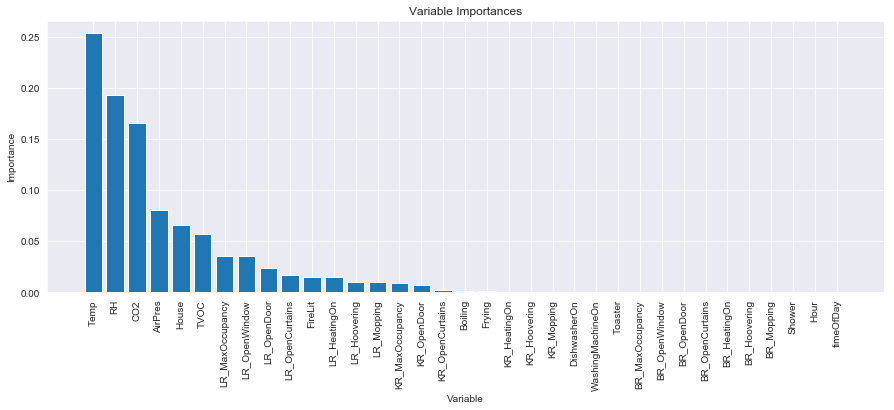

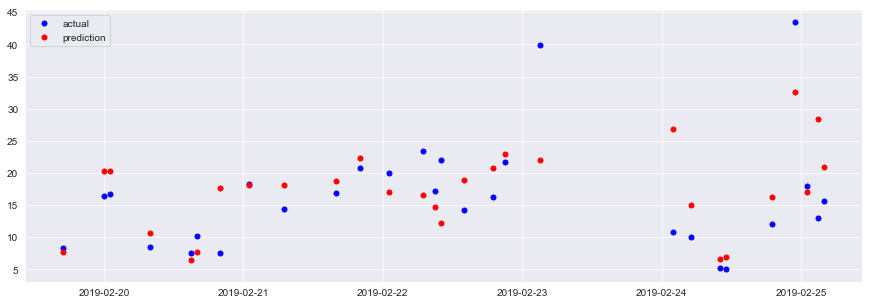

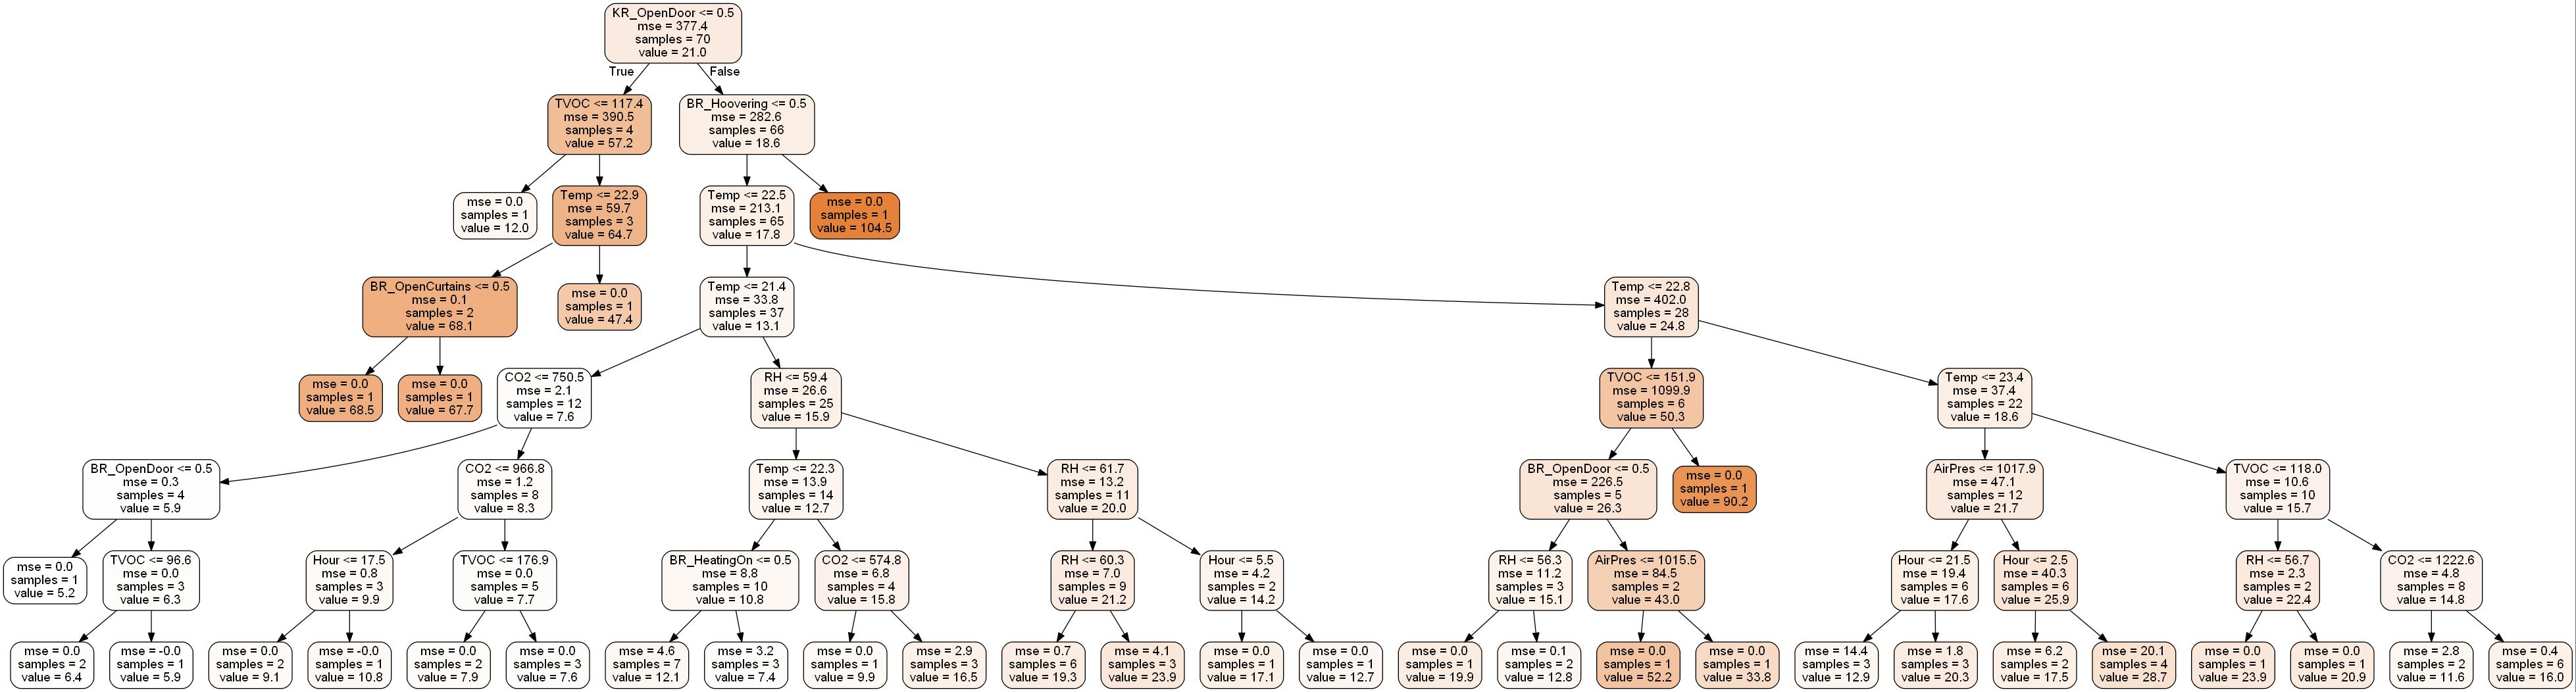

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [100]:
tuned_rf(LR2)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 4.32 degrees.
MAE: 3.92 degrees.
MAE Improvement over baseline: 9.18 %
MAPE Accuracy: 75.19 %.

RMSE: 6.224109608610693
Feature: CO2                  Weight: 0.237
Feature: RH                   Weight: 0.069
Feature: AirPres              Weight: 0.061
Feature: Temp                 Weight: 0.048
Feature: House                Weight: 0.0


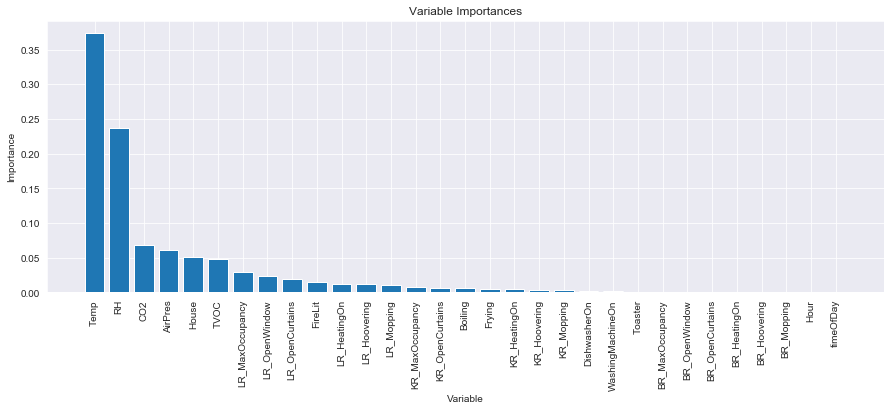

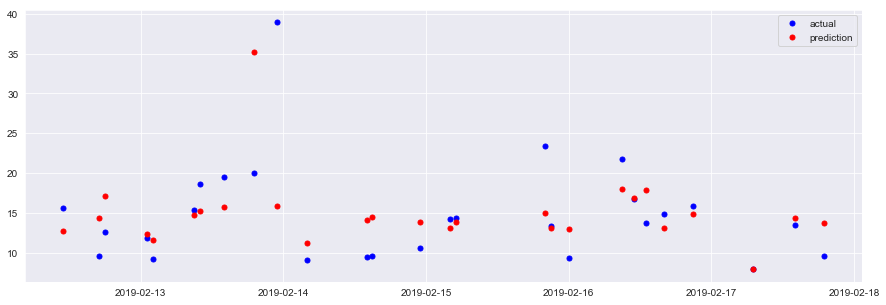

In [101]:
basic_rf(KR1)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 4.32 degrees.
MAE: 3.9 degrees.
MAE Improvement over baseline: 9.59 %
MAPE Accuracy: 75.89 %.

RMSE: 6.292013999005044
Feature: CO2                  Weight: 0.102
Feature: RH                   Weight: 0.067
Feature: AirPres              Weight: 0.038
Feature: Temp                 Weight: 0.033
Feature: House                Weight: 0.0


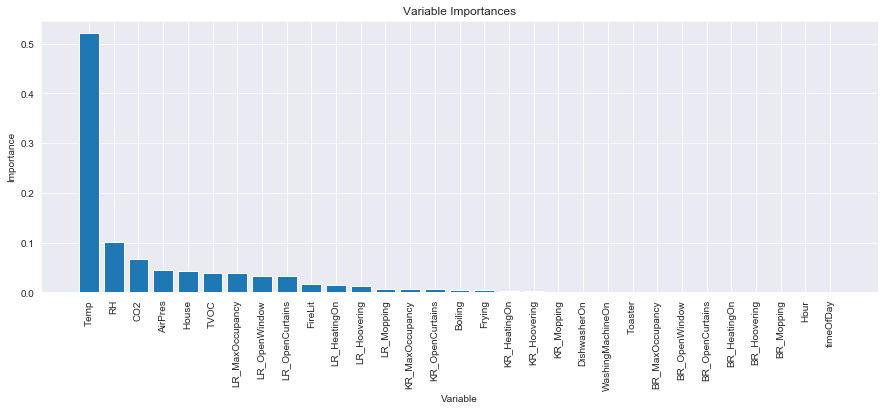

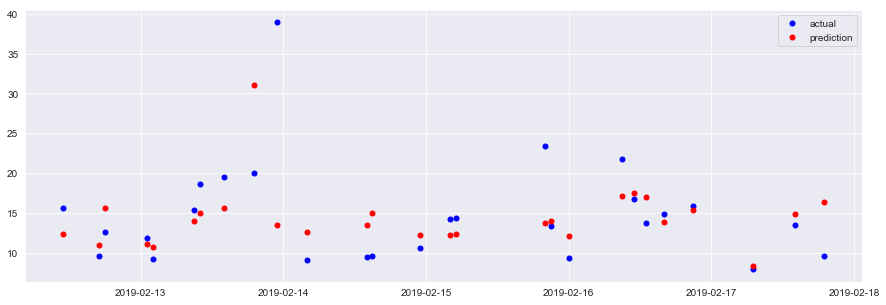

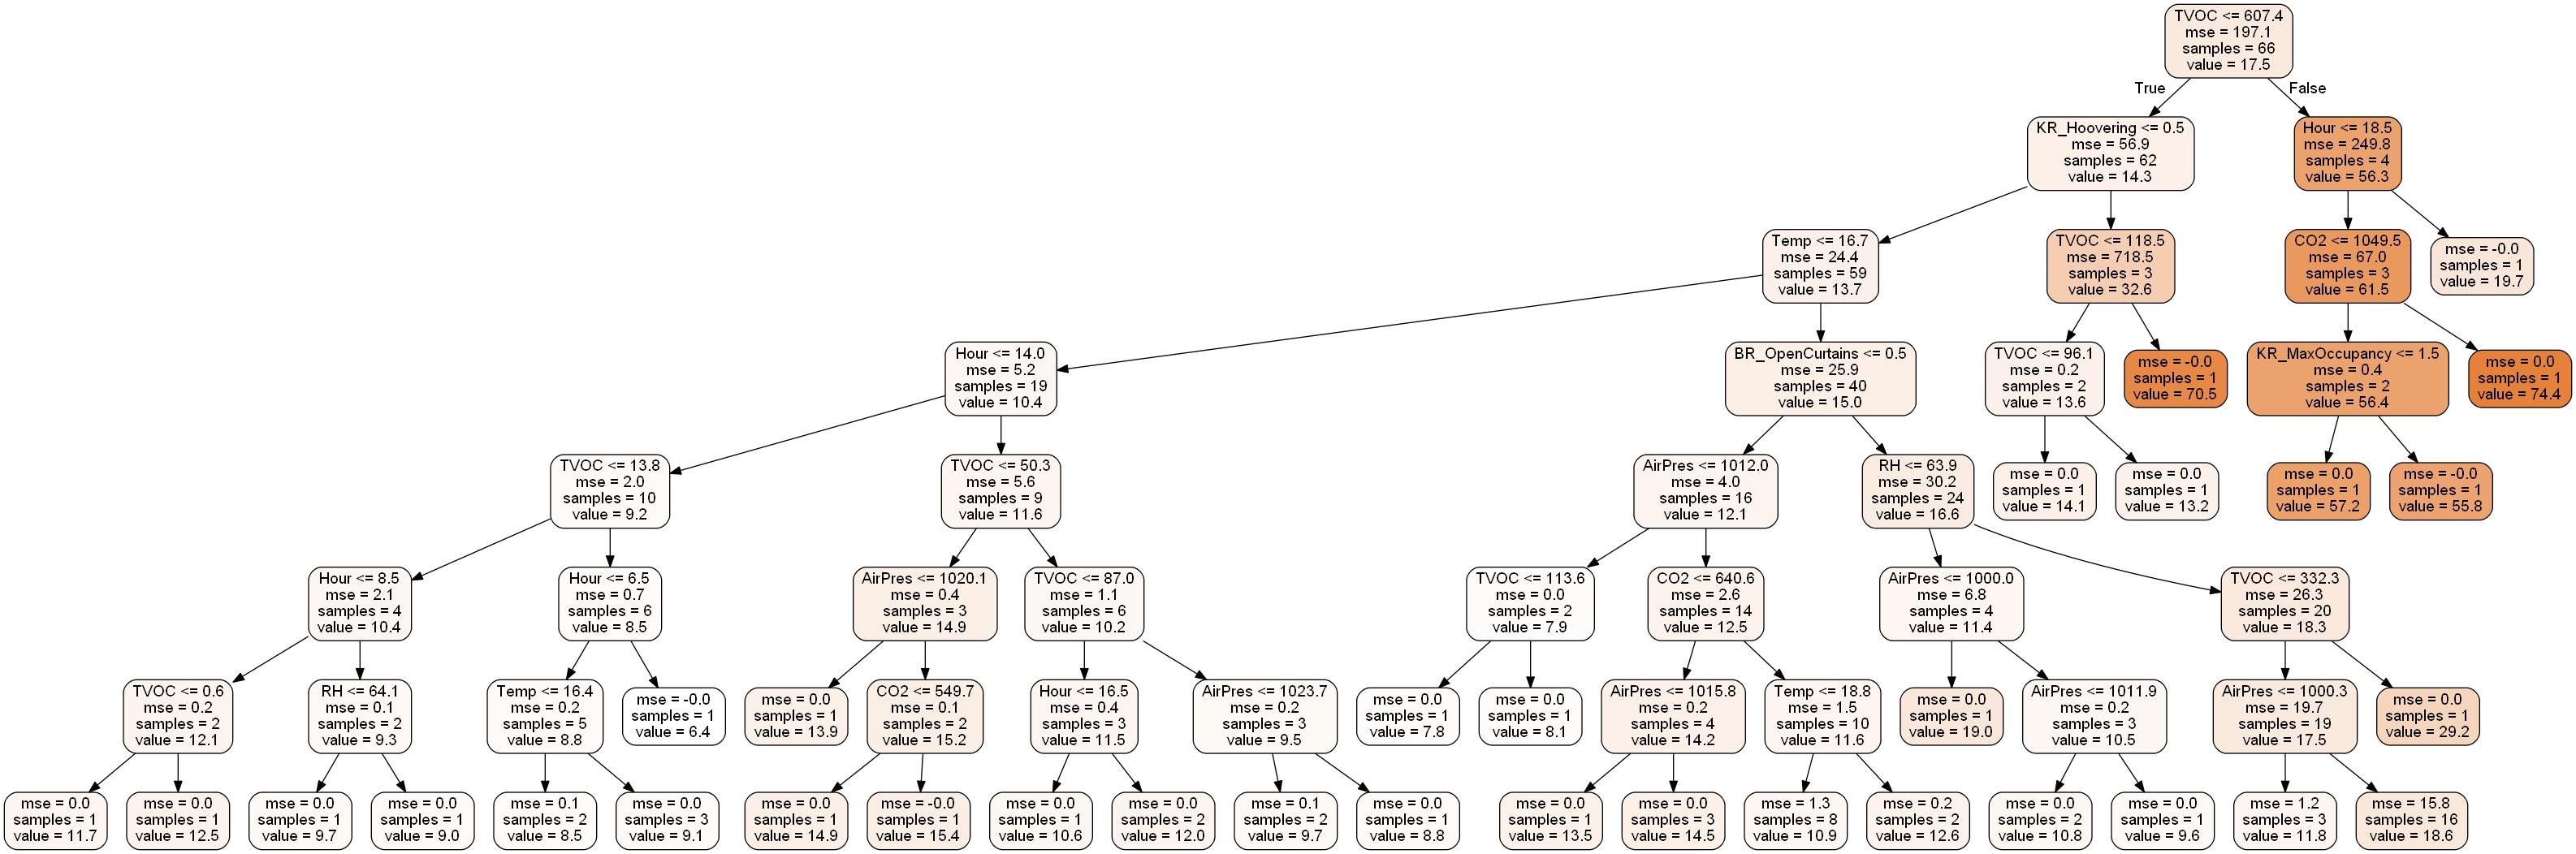

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [102]:
tuned_rf(KR1)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 3.96 degrees.
MAE: 3.19 degrees.
MAE Improvement over baseline: 19.44 %
MAPE Accuracy: 77.4 %.

RMSE: 5.749479125165537
Feature: Temp                 Weight: 0.144
Feature: RH                   Weight: 0.123
Feature: AirPres              Weight: 0.059
Feature: CO2                  Weight: 0.022
Feature: House                Weight: 0.0


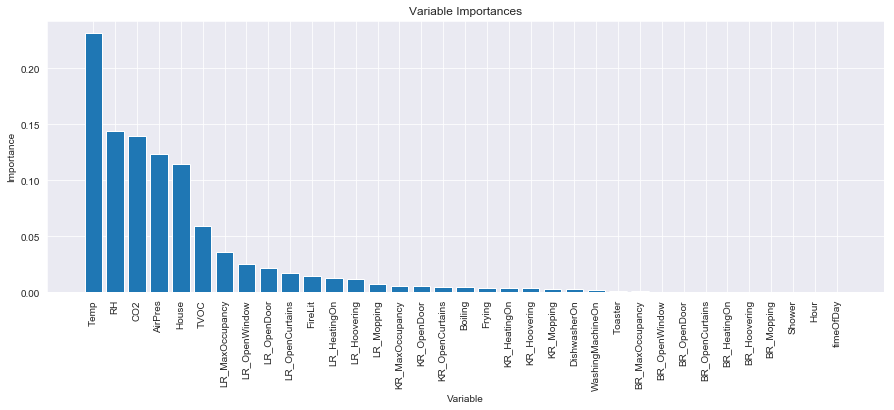

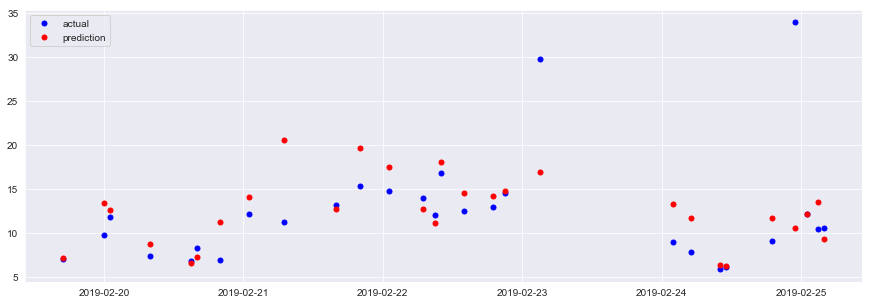

In [103]:
basic_rf(KR2)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 3.96 degrees.
MAE: 3.27 degrees.
MAE Improvement over baseline: 17.29 %
MAPE Accuracy: 76.92 %.

RMSE: 5.960335768092246
Feature: Temp                 Weight: 0.136
Feature: RH                   Weight: 0.131
Feature: AirPres              Weight: 0.034
Feature: CO2                  Weight: 0.009
Feature: House                Weight: 0.0


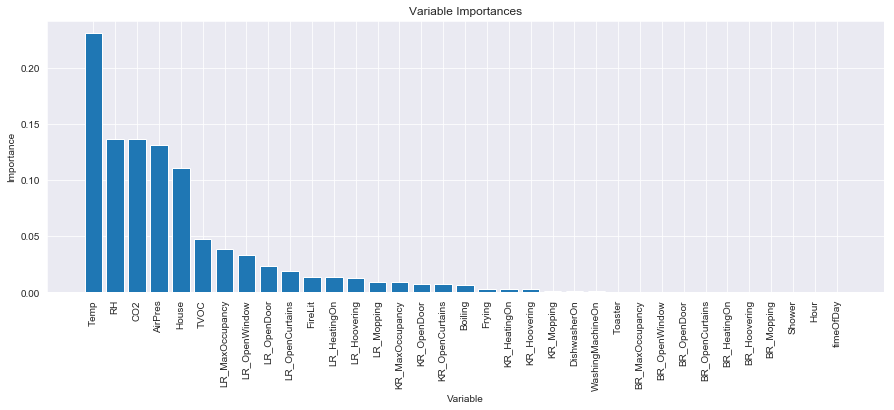

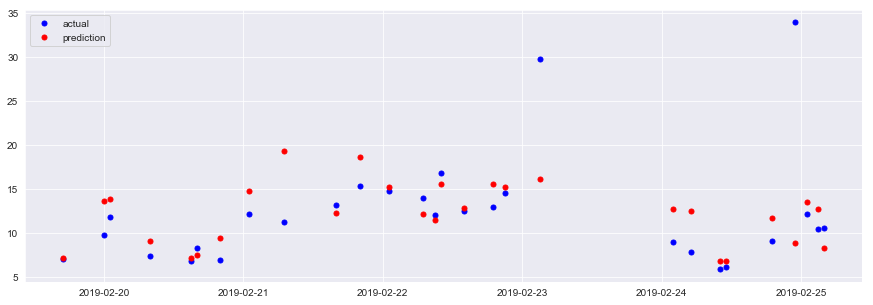

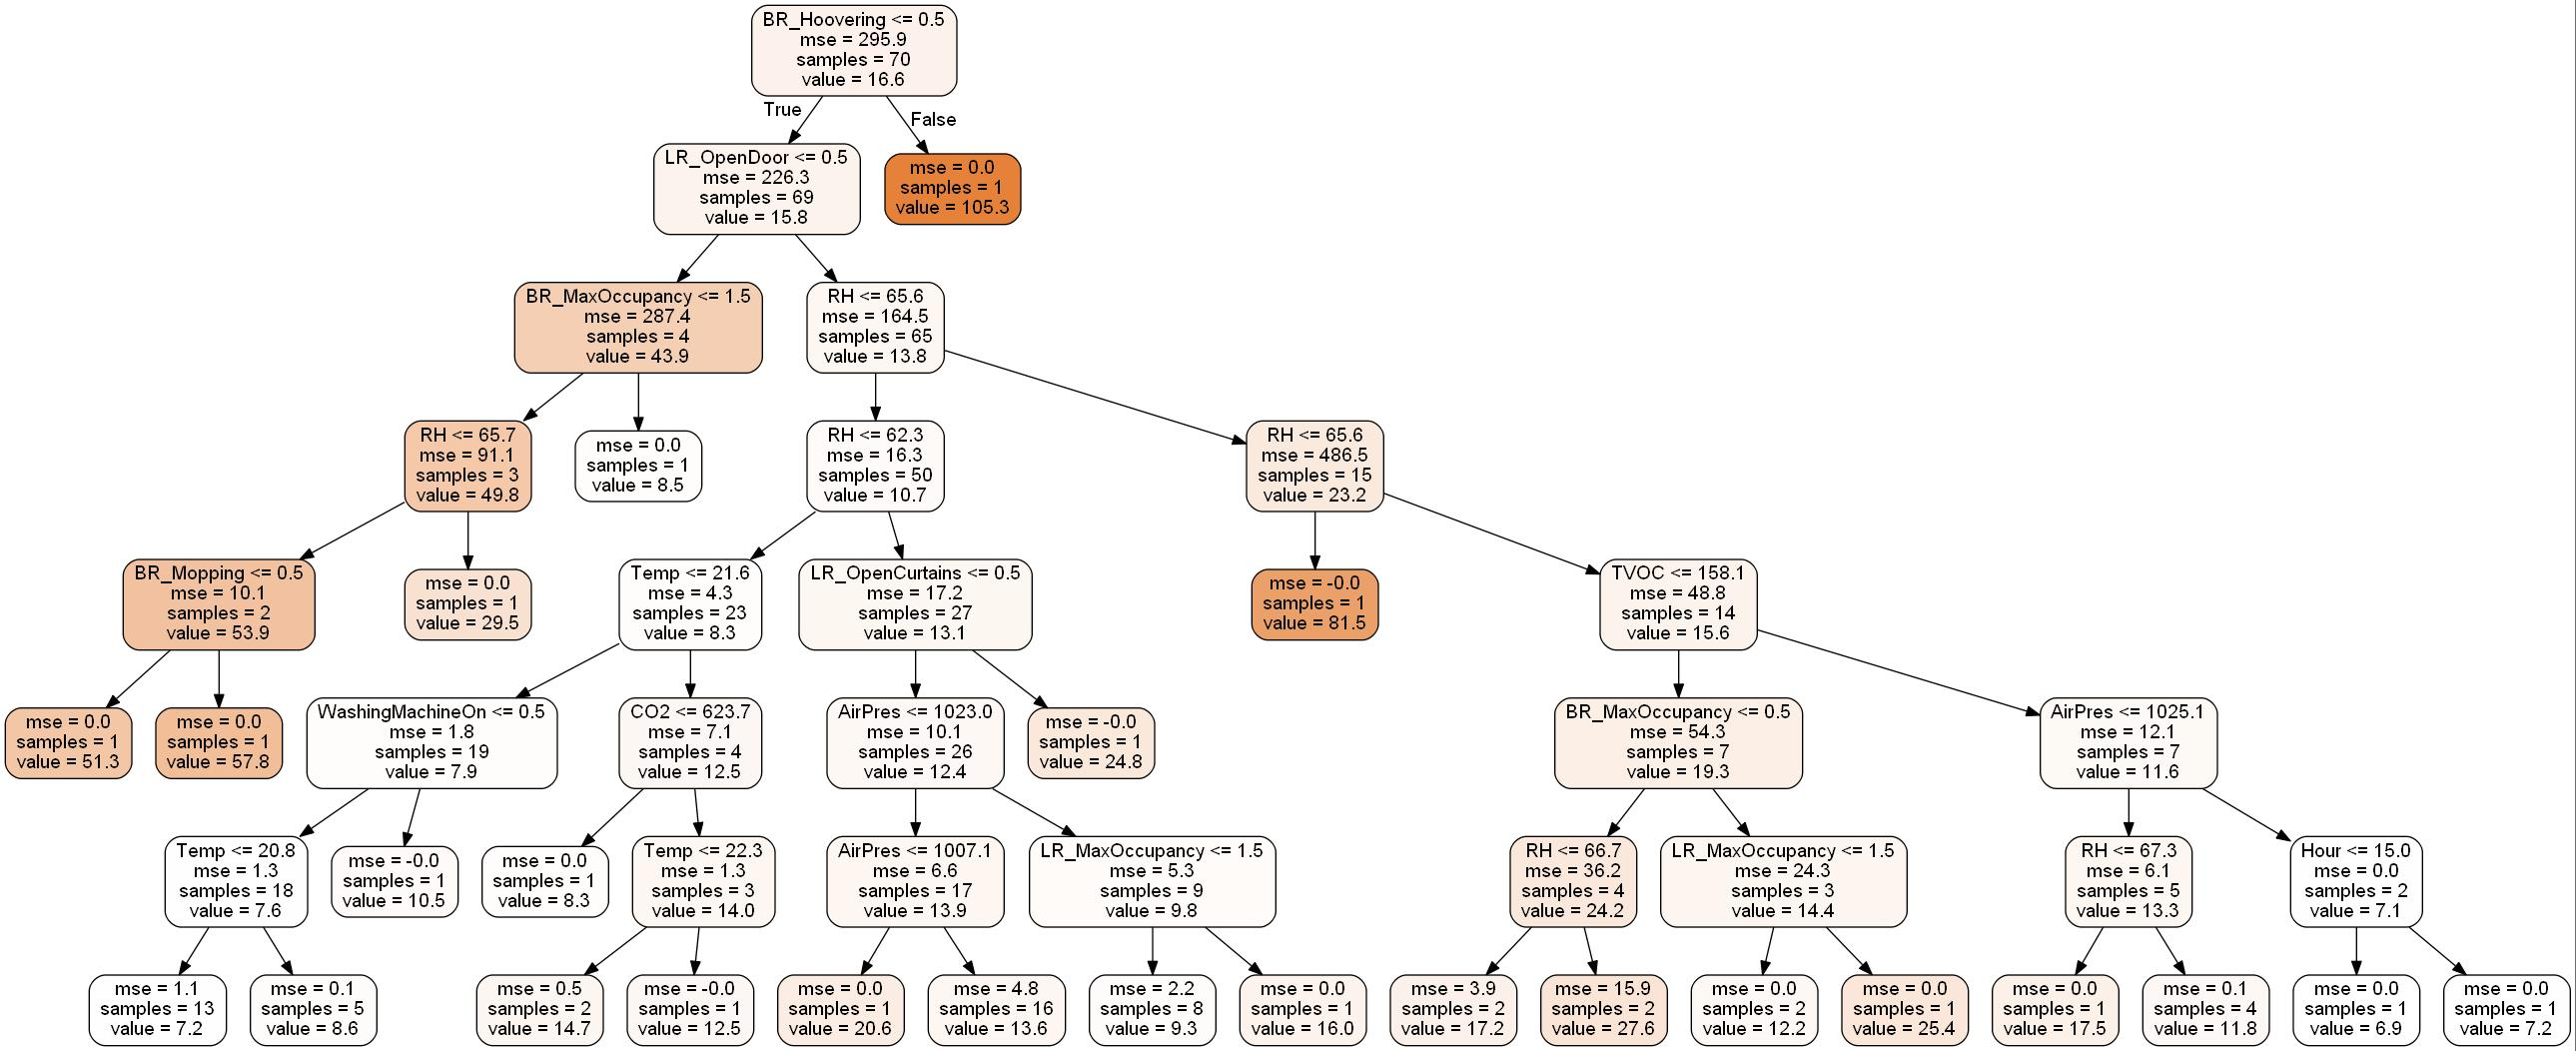

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [104]:
tuned_rf(KR2)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 3.94 degrees.
MAE: 2.94 degrees.
MAE Improvement over baseline: 25.41 %
MAPE Accuracy: 81.06 %.

RMSE: 4.388077289952012
Feature: CO2                  Weight: 0.238
Feature: AirPres              Weight: 0.181
Feature: RH                   Weight: 0.119
Feature: Temp                 Weight: 0.056
Feature: House                Weight: 0.0


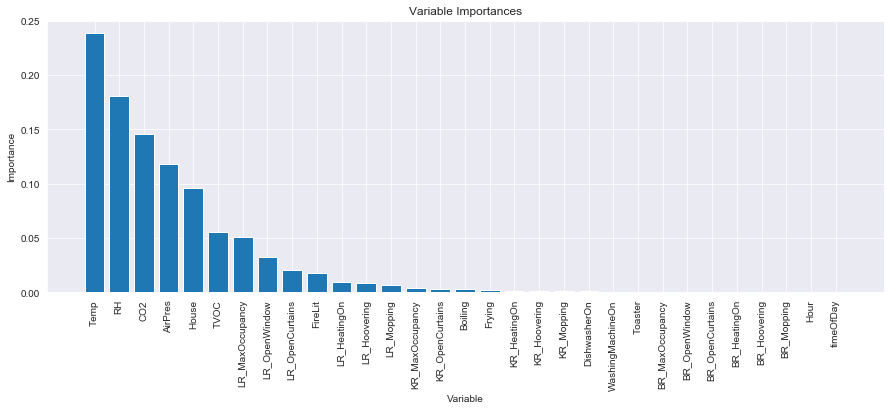

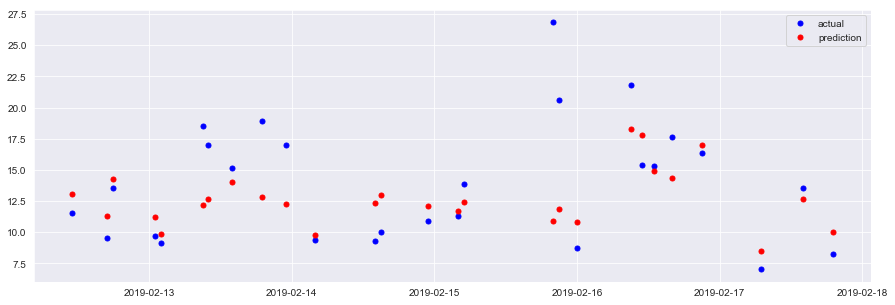

In [105]:
basic_rf(BR1)

Training Features Shape: (104, 31)
Training Labels Shape: (104,)
Testing Features Shape: (27, 31)
Testing Labels Shape: (27,) 

MAE baseline error: Mean of PM2.5 - 3.94 degrees.
MAE: 2.91 degrees.
MAE Improvement over baseline: 26.16 %
MAPE Accuracy: 80.87 %.

RMSE: 4.291379222491944
Feature: CO2                  Weight: 0.235
Feature: AirPres              Weight: 0.162
Feature: RH                   Weight: 0.147
Feature: Temp                 Weight: 0.035
Feature: House                Weight: 0.0


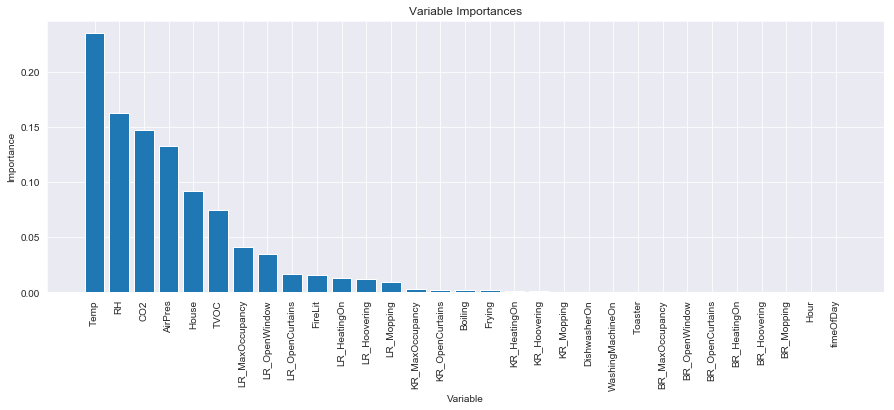

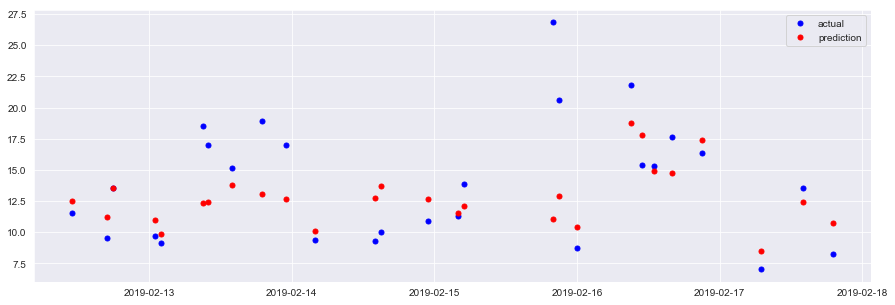

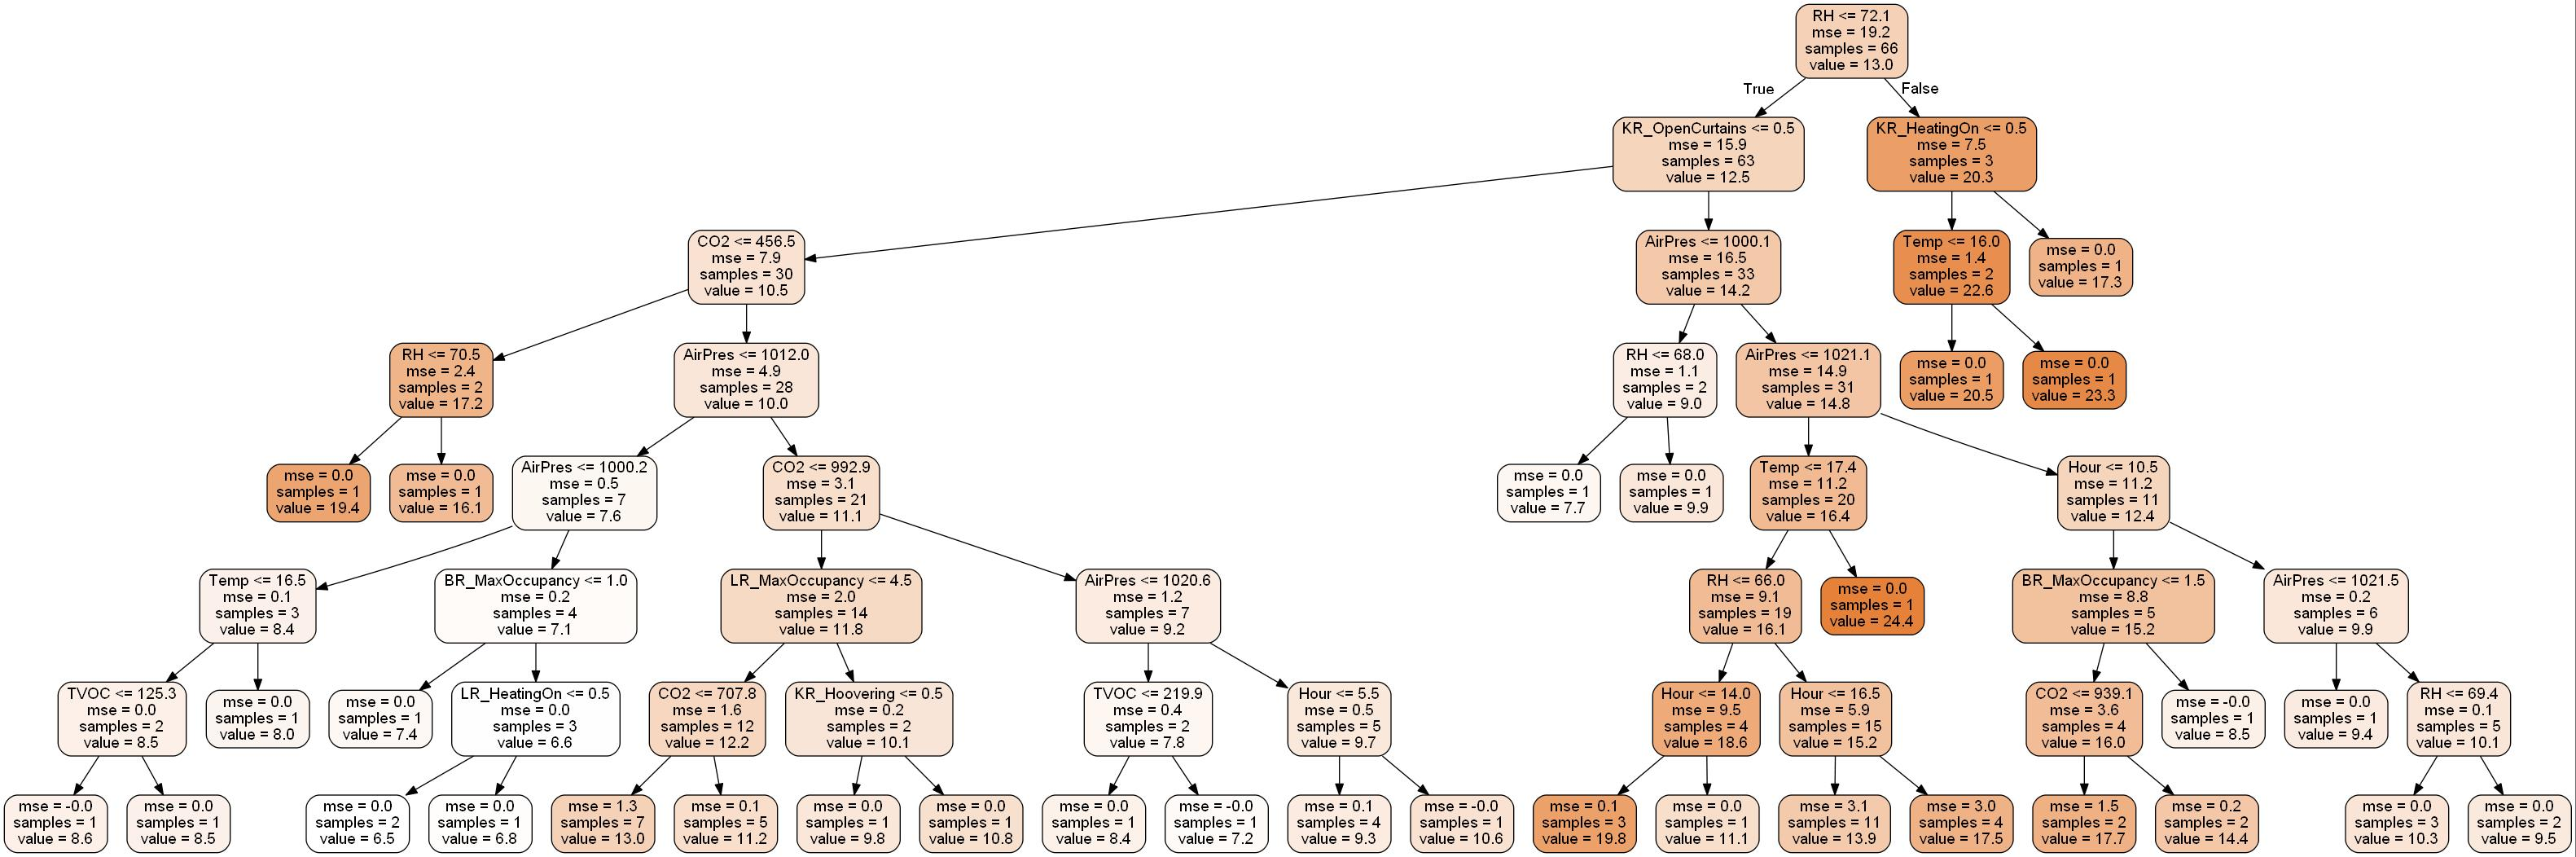

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [106]:
tuned_rf(BR1)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 4.31 degrees.
MAE: 3.15 degrees.
MAE Improvement over baseline: 26.86 %
MAPE Accuracy: 75.54 %.

RMSE: 4.112544665497781
Feature: AirPres              Weight: 0.133
Feature: CO2                  Weight: 0.097
Feature: Temp                 Weight: 0.069
Feature: RH                   Weight: 0.069
Feature: House                Weight: 0.0


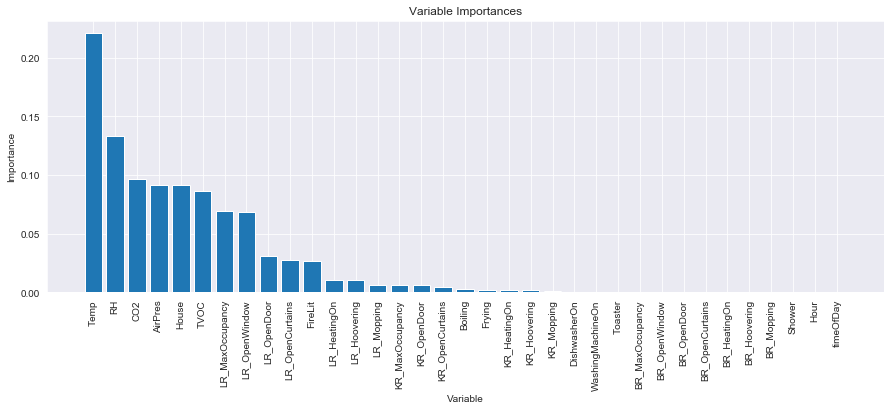

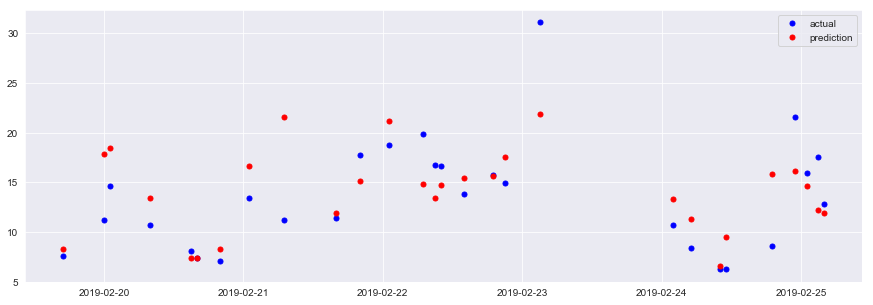

In [107]:
basic_rf(BR2)

Training Features Shape: (111, 35)
Training Labels Shape: (111,)
Testing Features Shape: (28, 35)
Testing Labels Shape: (28,) 

MAE baseline error: Mean of PM2.5 - 4.31 degrees.
MAE: 3.11 degrees.
MAE Improvement over baseline: 27.93 %
MAPE Accuracy: 74.99 %.

RMSE: 4.314618758682229
Feature: AirPres              Weight: 0.112
Feature: RH                   Weight: 0.083
Feature: CO2                  Weight: 0.08
Feature: Temp                 Weight: 0.052
Feature: House                Weight: 0.0


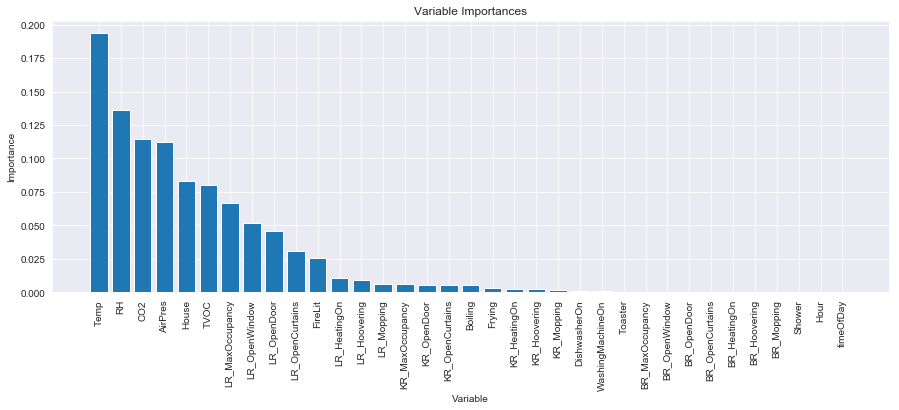

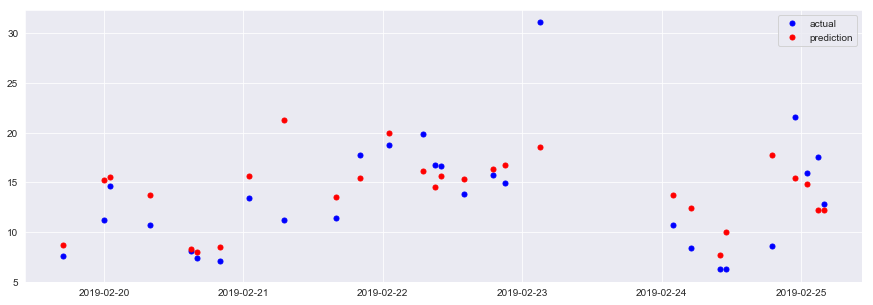

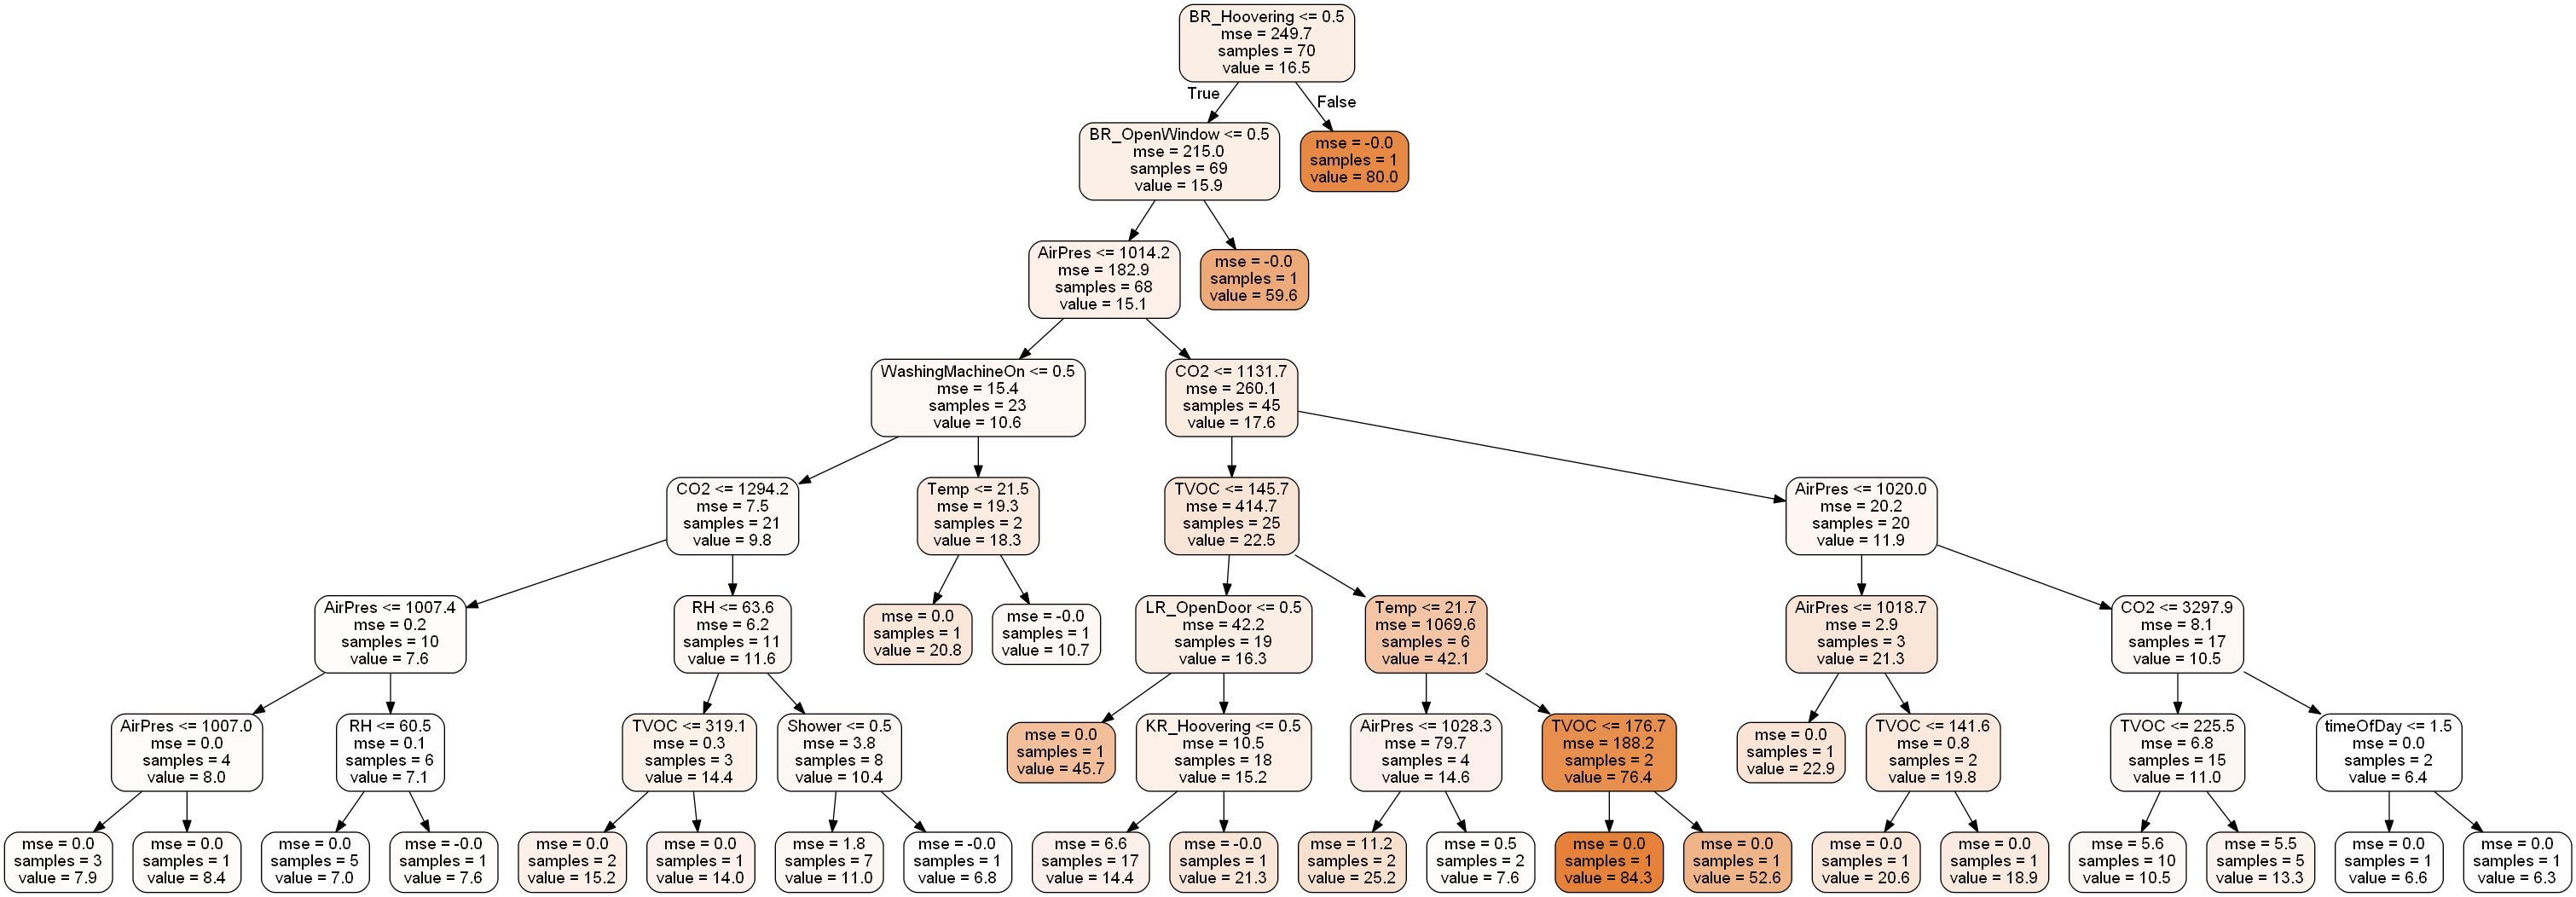

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [108]:
tuned_rf(BR2)

### Immediate considerations: Lower the tuned max_depth to give the models more interpretability at the cost of prediction power

In [81]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X_train, y_train);

selected_feat= X_train.columns[(sel.get_support())]
selected_feat

NameError: name 'X_train' is not defined

In [ ]:
xKR = pd.DataFrame(StandardScaler().fit_transform(KR), columns=KR.columns)
xKR1 = pd.DataFrame(StandardScaler().fit_transform(KR1), columns=KR1.columns)
xKR2 = pd.DataFrame(StandardScaler().fit_transform(KR2), columns=KR2.columns)

xBR = pd.DataFrame(StandardScaler().fit_transform(BR), columns=BR.columns)
xBR1 = pd.DataFrame(StandardScaler().fit_transform(BR1), columns=BR1.columns)
xBR2 = pd.DataFrame(StandardScaler().fit_transform(BR2), columns=BR2.columns)

xLR = pd.DataFrame(StandardScaler().fit_transform(LR), columns=LR.columns)
xLR1 = pd.DataFrame(StandardScaler().fit_transform(LR1), columns=LR1.columns)
xLR2 = pd.DataFrame(StandardScaler().fit_transform(LR2), columns=LR2.columns)

xH = pd.DataFrame(StandardScaler().fit_transform(H), columns=H.columns)
xH1 = pd.DataFrame(StandardScaler().fit_transform(H1), columns=H1.columns)
xH2 = pd.DataFrame(StandardScaler().fit_transform(H2), columns=H2.columns)
